In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.mixed_linear_model import MixedLM
import pingouin as pg

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
figdir = "C://Users/esay/data/Stx3/YMazeResults/neural/reward_overrep"
os.makedirs(figdir, exist_ok = True)

In [2]:
df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                })



In [4]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice

In [5]:
sparse_mice

('SparseKO_02',
 'SparseKO_06',
 'SparseKO_08',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

In [61]:
class LMM_PeriRewardPlaceCellFrac:

    def __init__(self, days = np.arange(6), ts_key = 'spks_smooth'):

        '''


        :param days:
        :param ts_key:
        '''
        
        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.sparse_mice =stx.ymaze_sess_deets.sparse_mice
        self.__dict__.update({'days': days, 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                })
        self.fill_df()
        

    def fill_df(self):
        # for m, mouse in enumerate(self.ctrl_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse,day),m,0,day)
                
        # for m, mouse in enumerate(self.ko_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse, day),m+len(self.ctrl_mice), 1,day)
                
        for m, mouse in enumerate(self.sparse_mice):
            if mouse == 'SparseKO_12':
                self.days = np.arange(2)
            elif mouse == 'SparseKO_09':
                self.days = np.arange(5)
            else:
                self.days = np.arange(6)
            for day in self.days:
                self.argmax_perireward_ES(u.load_single_day(mouse, day),m+len(self.sparse_mice), 1,day, is_sparse=True) 
            
        
    def argmax_perireward_ES(self, sess, m, ko, day, ts_key: str = 'spks_smooth', is_sparse=False):
        '''
        :param sess: session object
        :param m: mouse index
        :param ko: knockout indicator
        :param day: experimental day
        :param ts_key: time series key
        :param is_sparse: flag indicating if sparse_mice is being processed
        '''
                    
        # if mouse in self.sparse_mice:
            
        for chan in ['channel_0', 'channel_1']:

                
            trials_mat = sess.trial_matrices[f"{chan}_{ts_key}"]
            bin_edges = sess.trial_matrices['bin_edges']
            for _arm, arm in enumerate([-1, 1]):
                trial_mask = sess.trial_info['LR'] == arm
                if sess.novel_arm == arm:

                    cell_mask = sess.nov_place_cell_mask(mux = True, chan = chan, key =ts_key)
                    rzone_front = np.argwhere(
                        (sess.rzone_nov['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_nov['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'nov'
                else:
                        
                    cell_mask = sess.fam_place_cell_mask(mux= True, chan=chan, key =ts_key)
                    rzone_front = np.argwhere(
                        (sess.rzone_fam['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_fam['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'fam'
                # Smooth ratemap by 1 bin
                ratemap = sp.ndimage.gaussian_filter1d(
                    np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0
                )
                max_inds = np.argmax(ratemap[:, cell_mask], axis=0) - rzone_front
                reward_frac = self.get_frac(max_inds)
                # Add to dataframe
                self.df = pd.concat((
                    self.df,
                    pd.DataFrame({
                        'mouse': sess.mouse,
                        'ko': ko,
                        'day': day,
                        'lr': _arm,
                        'novfam': nov,
                        'channel': chan,  # Add channel info to the dataframe
                        'frac': reward_frac
                    }, index=[len(self.df)])
                ), ignore_index=True)

    
    @staticmethod
    def get_frac(data):
        '''

        :param frac:
        :return:
        '''
        x = np.arange(-30, 15)
        anova_mask = (x >= -6) * (x <= -2)

        hist = np.array([np.count_nonzero(data.ravel() == _bin) for _bin in x.tolist()])
        hist = hist / hist.sum()
        # return hist[anova_mask].sum() / hist[~anova_mask].sum()
        return hist[anova_mask].sum() / hist.sum()

    

In [62]:
lmm_frac = LMM_PeriRewardPlaceCellFrac()

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

C:\Users\esay\AppData\Local\Temp\ipykernel_153564\1459527411.py:85: RuntimeWarning: Mean of empty slice
  np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0
C:\Users\esay\AppData\Local\Temp\ipykernel_153564\1459527411.py:115: RuntimeWarning: invalid value encountered in divide
  hist = hist / hist.sum()


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


In [63]:
lmm_frac.df.to_pickle("C:/Users/esay/data/Stx3/YMazeSessPkls/df_rewardfrac_spks_smooth.pkl")

In [395]:
import dill
filename = 'C://Users/esay/data/Stx3/sparse_analyses/reward/df_rewardfrac_spks.pkl'
with open(filename, 'rb') as file:
    lmm_frac.df=dill.load(file)

In [64]:
nov = lmm_frac.df[lmm_frac.df['novfam'] == 'nov']
fam = lmm_frac.df[lmm_frac.df['novfam'] == 'fam']

In [65]:
import pingouin as pg
nov = lmm_frac.df[lmm_frac.df['novfam'] == 'nov']
fam = lmm_frac.df[lmm_frac.df['novfam'] == 'fam']
pg.rm_anova(data=nov, dv='frac', within='channel', subject='mouse', correction='auto', detailed=False, effsize='ng2')
pg.rm_anova(data=fam, dv='frac', within='channel', subject='mouse', correction='auto', detailed=False, effsize='ng2')

Source  ddof1  ddof2         F    p-unc       ng2  eps
0  channel      1      5  2.942975  0.14691  0.179461  1.0

In [66]:
pg.rm_anova(data=fam, dv='frac', within='channel', subject='mouse', correction='auto', detailed=False, effsize='ng2')

Source  ddof1  ddof2          F     p-unc       ng2  eps
0  channel      1      5  10.284704  0.023809  0.294416  1.0

In [129]:
# change names to run statistical testing (DO NOT RUN)
for i in range(len(lmm_frac.df)):
    if lmm_frac.df['channel'][i] == 'channel_0':
        lmm_frac.df['chan'][i] = 0
        lmm_frac.df['mouse'][i] = lmm_frac.df['mouse'][i][: -2 ]
    else:
        lmm_frac.df['chan'][i] = 1
        lmm_frac.df['mouse'][i] = lmm_frac.df['mouse'][i][: - 2]

    

C:\Users\esay\AppData\Local\Temp\ipykernel_104912\243814262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_frac.df['chan'][i] = 0
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\243814262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_frac.df['mouse'][i] = lmm_frac.df['mouse'][i][: -2 ]
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\243814262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_frac.df['chan']

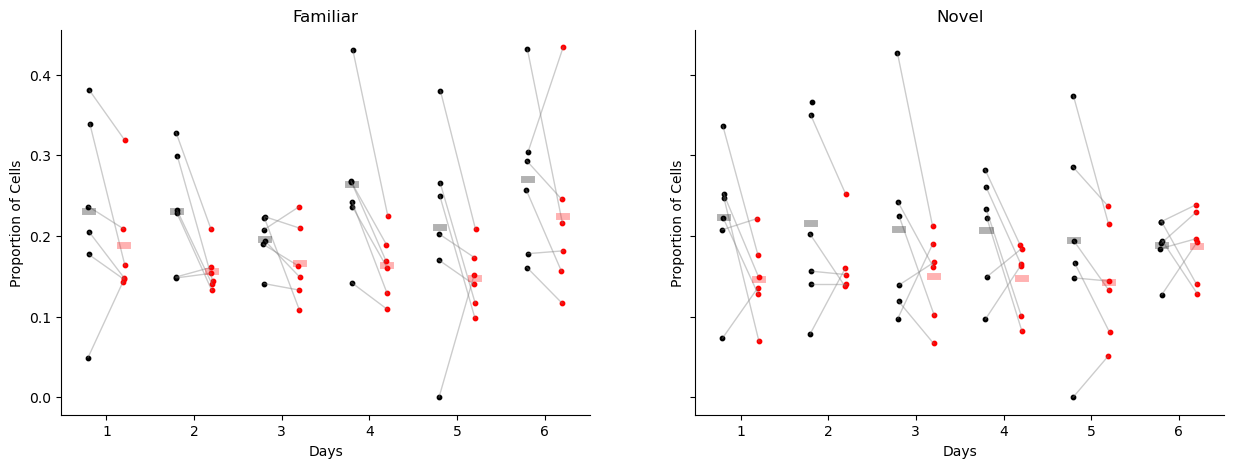

In [67]:
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
s = 10
lw = 5

for day in range(6):
    for novfam, axis_idx in zip(['fam', 'nov'], [0, 1]):
        frac_ch1 = []
        frac_ch0 = []
        xvals_ch1 = []
        xvals_ch0 = []

        for i, mouse in enumerate(sparse_mice):
            mask_ch1 = (
                (lmm_frac.df['channel'] == 'channel_1') &
                (lmm_frac.df['day'] == day) &
                (lmm_frac.df['novfam'] == novfam) &
                (lmm_frac.df['mouse'] == mouse)
            )
            mask_ch0 = (
                (lmm_frac.df['channel'] == 'channel_0') &
                (lmm_frac.df['day'] == day) &
                (lmm_frac.df['novfam'] == novfam) &
                (lmm_frac.df['mouse'] == mouse)
            )

            vals_ch1 = lmm_frac.df['frac'].loc[mask_ch1]._values
            vals_ch0 = lmm_frac.df['frac'].loc[mask_ch0]._values

            x1 = 5 * day - 1 if novfam == 'fam' else 5 * day - 1
            x0 = 5 * day + 1 if novfam == 'fam' else 5 * day + 1
            offset = np.linspace(-0.05, 0.05, num=len(sparse_mice))[i]

            if len(vals_ch1):
                frac = vals_ch1.mean()
                frac_ch1.append(frac)
                xvals_ch1.append(x1 + offset)
                ax[axis_idx].scatter(x1 + offset, frac, color='black', s=s)

            if len(vals_ch0):
                frac = vals_ch0.mean()
                frac_ch0.append(frac)
                xvals_ch0.append(x0 + offset)
                ax[axis_idx].scatter(x0 + offset, frac, color='red', s=s)

            # Draw line between ch1 and ch0 points for this mouse if both exist
            if len(vals_ch1) and len(vals_ch0):
                ax[axis_idx].plot(
                    [x1 + offset, x0 + offset],
                    [vals_ch1.mean(), vals_ch0.mean()],
                    color='gray', alpha=0.4, linewidth=1
                )

        # Plot group mean bars
        if frac_ch1:
            ax[axis_idx].plot(
                x1 + np.array([-0.2, 0.2]),
                [np.mean(frac_ch1)] * 2,
                color='black', linewidth=lw, alpha=0.3
            )
        if frac_ch0:
            ax[axis_idx].plot(
                x0 + np.array([-0.2, 0.2]),
                [np.mean(frac_ch0)] * 2,
                color='red', linewidth=lw, alpha=0.3
            )

ax[0].set_title('Familiar')
ax[1].set_title('Novel')

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Proportion of Cells")
    ax[a].set_xticks(5 * np.arange(6))
    ax[a].set_xticklabels(np.arange(1, 7))


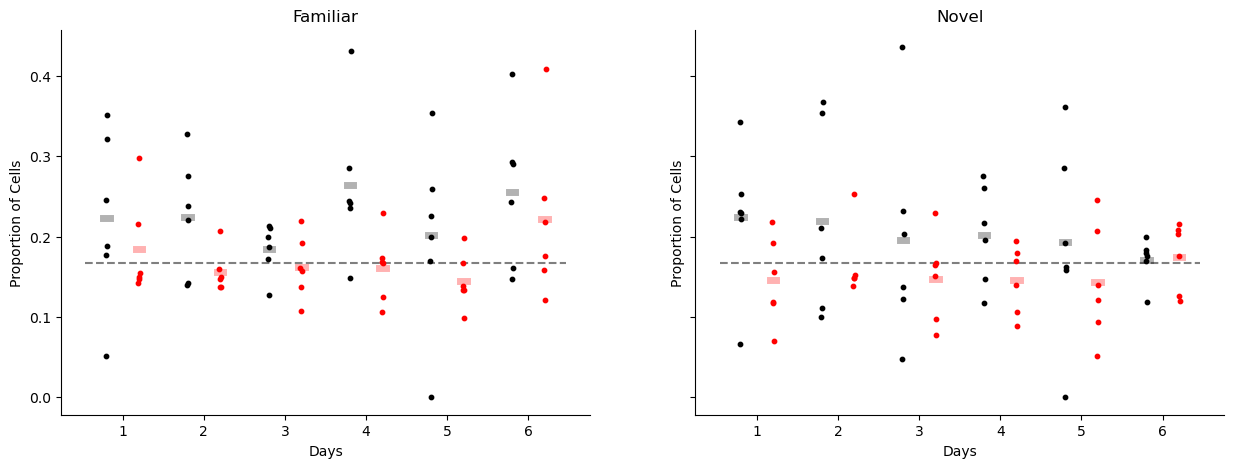

In [10]:
fig, ax = plt.subplots(1,2,figsize = [15,5], sharey=True)
s = 10
lw = 5
for day in range(6):
    mask = (lmm_frac.df['channel']=='channel_1') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s)
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['channel']=='channel_1') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s, alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['channel']=='channel_0') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth =lw, alpha = .3)
    
    mask = (lmm_frac.df['channel']=='channel_0') & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day +1+ np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    ax[0].set_title('Familiar')
    ax[1].set_title('Novel')

    
ax[0].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Proportion of Cells")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
# fig.savefig(os.path.join(figdir, 'reward_frac_summary.pdf'))

C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:6: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:12: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:17: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
C:\Users\esay\AppData\Local\Temp\ipykernel_104912\1954521583.py:22: RuntimeWarning: Mean of empty slice.
  frac = np.array([lmm_frac.df[

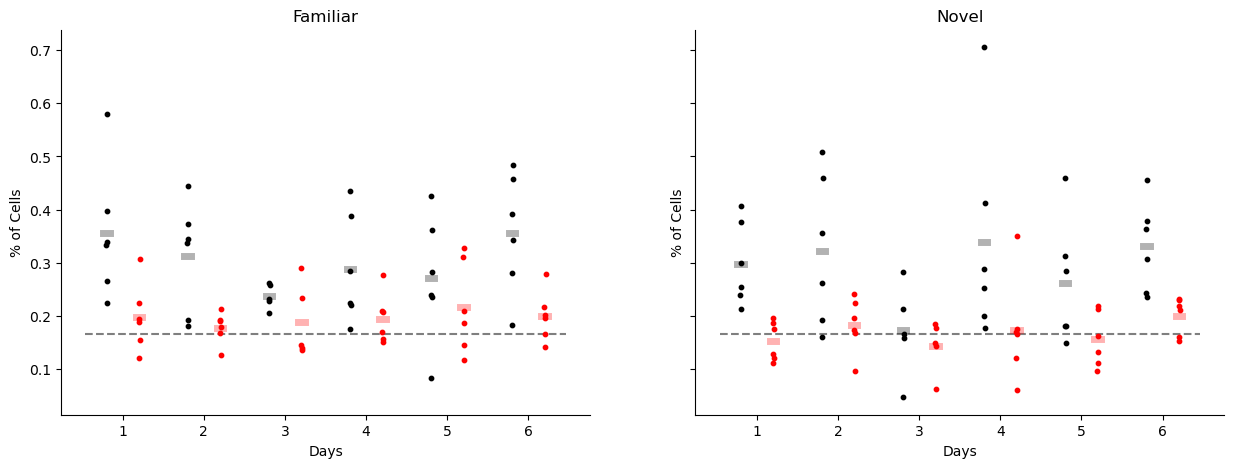

In [192]:
# DO NOT RUN
fig, ax = plt.subplots(1,2,figsize = [15,5], sharey=True)
s = 10
lw = 5
for day in range(6):
    mask = (lmm_frac.df['chan']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s)
    
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['chan']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'black', s=s, alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['chan']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='red', linewidth =lw, alpha = .3)
    
    mask = (lmm_frac.df['chan']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(sparse_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day +1+ np.array([-0.2,0.2]), np.nanmean(frac)*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    ax[0].set_title('Familiar')
    ax[1].set_title('Novel')

    '''
     Dashed line indicates the proportion of reward coding neurons expected by random remapping between novel and familiar arms with constant coding for the stem of the maze. 
     '''
    
ax[0].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("% of Cells")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
# fig.savefig(os.path.join(figdir, 'reward_frac_summary.pdf'))

In [15]:
lmm_frac.df

mouse   ko  day   lr novfam      frac    channel
0    SparseKO_02  1.0  0.0  0.0    nov  0.218543  channel_0
1    SparseKO_02  1.0  0.0  1.0    fam  0.142292  channel_0
2    SparseKO_02  1.0  0.0  0.0    nov  0.230769  channel_1
3    SparseKO_02  1.0  0.0  1.0    fam  0.051724  channel_1
4    SparseKO_02  1.0  1.0  0.0    nov  0.138686  channel_0
..           ...  ...  ...  ...    ...       ...        ...
139  SparseKO_13  1.0  4.0  1.0    nov  0.158730  channel_1
140  SparseKO_13  1.0  5.0  0.0    fam  0.409326  channel_0
141  SparseKO_13  1.0  5.0  1.0    nov  0.120000  channel_0
142  SparseKO_13  1.0  5.0  0.0    fam  0.289855  channel_1
143  SparseKO_13  1.0  5.0  1.0    nov  0.176471  channel_1

[144 rows x 7 columns]

0.0 0.03125


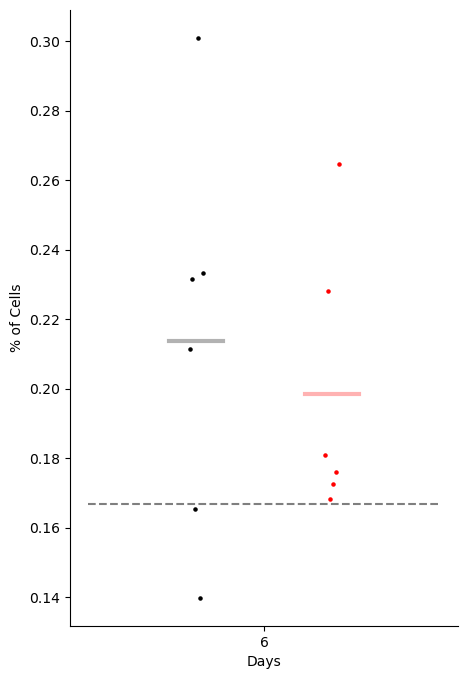

In [16]:
fig, ax = plt.subplots(figsize=[5,8])

# somehow fix so this can plot day 6 for all mice (9 is currently missing one day)
for day in [5]: #range(5,6):
    mask = (lmm_frac.df['channel']=='channel_1') & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ctrl_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(sparse_mice)), ctrl_frac, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    
    mask = (lmm_frac.df['channel']=='channel_0') & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ko_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in sparse_mice])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(sparse_mice)), ko_frac, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))

ax.plot([23.7, 26.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
    
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
t,p = sp.stats.wilcoxon(ko_frac-4/30)
print(t,p)
# fig.savefig(os.path.join(figdir, "reward_pc_frac_summary_short.pdf"))

In [351]:
sess.place_cell_info.keys()

dict_keys(['channel_0_F_dff', 'channel_1_F_dff'])

In [354]:
fam_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=True, days = np.arange(6))

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

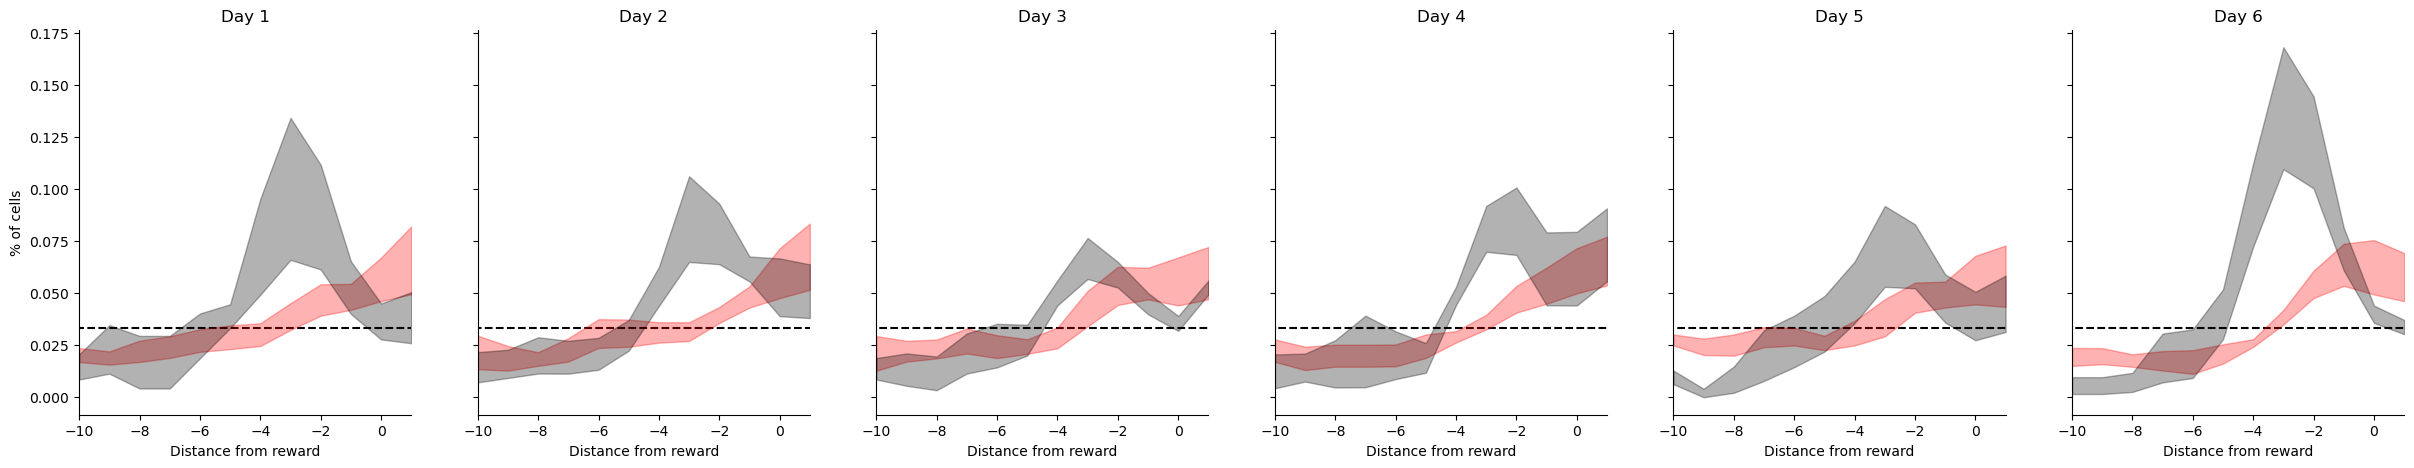

In [355]:
fig,ax = fam_pc_fracs.perireward_hist()
# fig.savefig(os.path.join(figdir,'fam_placecell_frac_perireward.pdf'),format='pdf')

In [356]:
nov_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=False)

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:211: RuntimeWarning: Mean of empty slice
  ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:295: RuntimeWarning: invalid value encountered in divide
  hist = hist / hist.sum()
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:296: RuntimeWarning: invalid value encountered in divide
  hist_sm = hist_sm / hist_sm.sum()


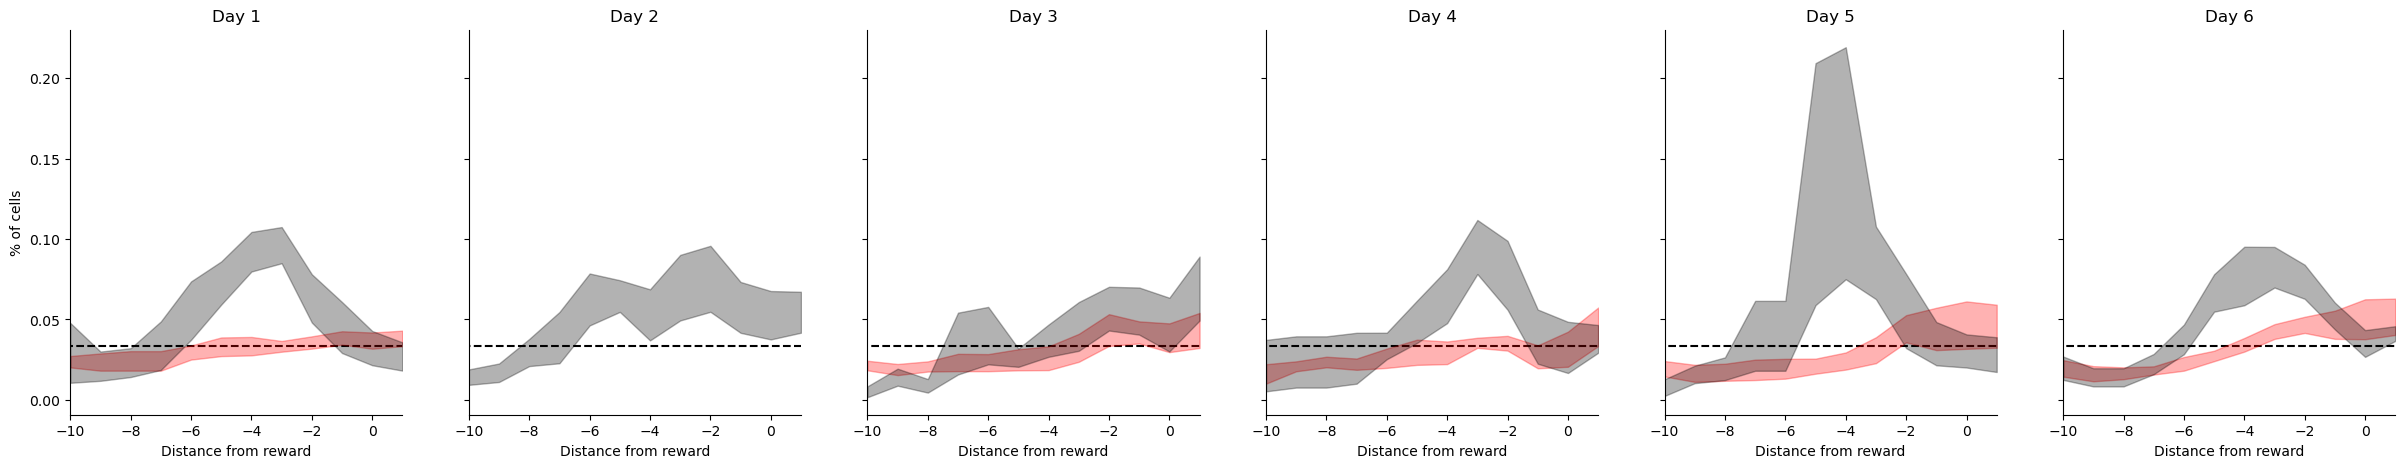

In [357]:
fig,ax = nov_pc_fracs.perireward_hist()
# fig.savefig(os.path.join(figdir,"nov_placecell_frac_perireward.pdf"),format = 'pdf')


In [34]:
sess = u.load_single_day ('SparseKO_06', 0)
sess.place_cell_info['channel_0_spks'].keys()

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


dict_keys(['left', 'right'])

In [35]:
def get_smooth_hist(max1, max2,bins = np.arange(0,30)):
    hist, xedges, yedges = np.histogram2d(max1,max2, bins = [bins, bins], density = True)
    hist_sm = sp.ndimage.gaussian_filter(hist, (1,1))
    hist_sm /= hist_sm.ravel().sum()
    return hist_sm


def _get_lr_map(sess, chan):
    ts_key = chan + '_spks'
    left_mask = sess.trial_info['LR']==-1
    pc_mask = np.zeros([sess.trial_matrices[ts_key].shape[-1],])

    for arm in ('left', 'right'):
        if len(sess.place_cell_info[ts_key][arm]['masks'].shape)>1:
            pc_mask += 1*sess.place_cell_info[ts_key][arm]['masks'].sum(axis=0)
        else:
            pc_mask += 1*sess.place_cell_info[ts_key][arm]['masks']
        
    pc_mask = pc_mask>0

    
    return np.nanmean(sess.trial_matrices[ts_key][left_mask,1:-1,:],axis=0)[:,pc_mask], np.nanmean(sess.trial_matrices[ts_key][~left_mask,1:-1,:],axis=0)[:,pc_mask]
 
def get_lr_maps(mice):
    left_mats, right_mats = {}, {}
    for mouse in mice:
        left_mats[mouse]={}
        right_mats[mouse]={}
        for day in range(6):
            for chan in ['channel_0', 'channel_1']:
                left_mats[mouse][chan] = []
                right_mats[mouse][chan] = []
                
                _left_mat, _right_mat = _get_lr_map(u.load_single_day(mouse,day),chan)
                left_mats[mouse][chan].append(_left_mat)
                right_mats[mouse][chan].append(_right_mat)
    return left_mats, right_mats


    

In [44]:
left_mats, right_mats = get_lr_maps(sparse_mice)

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session'

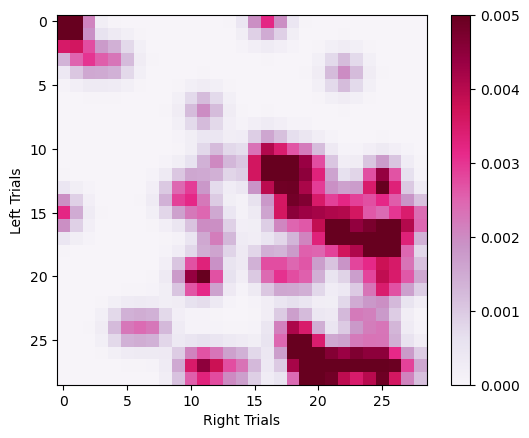

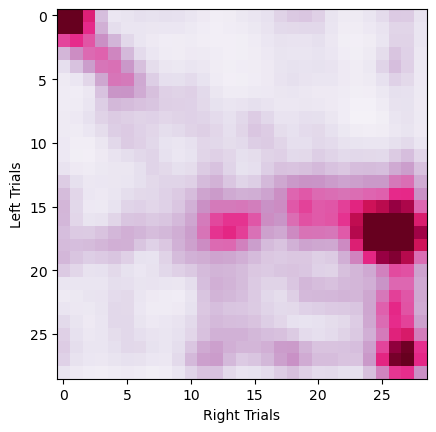

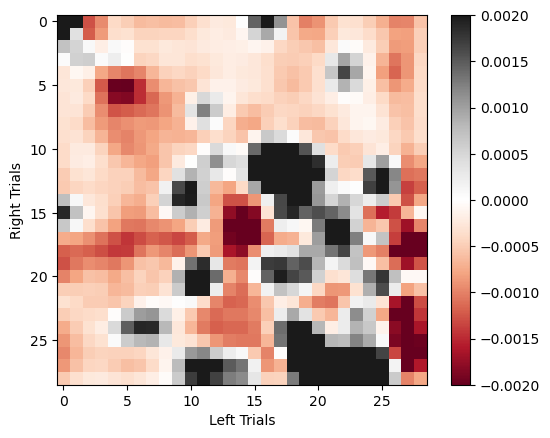

In [46]:
day = 0

ctrl_hist_sm = 0
for mouse in sparse_mice[:1]:
    ctrl_hist_sm += get_smooth_hist(np.argmax(left_mats[mouse]['channel_1'][day],axis=0), np.argmax(right_mats[mouse]['channel_1'][day],axis=0))
ctrl_hist_sm /= len(sparse_mice)
ctrl_hist_sm /= ctrl_hist_sm.ravel().sum()

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")

# DEFINE Rz early and rz late!!!!!
# ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
# ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
# fig.savefig(os.path.join(figdir,"ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

ko_hist_sm = 0
for mouse in sparse_mice:
    ko_hist_sm += get_smooth_hist(np.argmax(left_mats[mouse]['channel_0'][day],axis=0), np.argmax(right_mats[mouse]['channel_0'][day],axis=0))
ko_hist_sm /= len(sparse_mice)
ko_hist_sm /= ko_hist_sm.ravel().sum()

fig,ax = plt.subplots()
ax.imshow(ko_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")

# ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
# ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
# fig.savefig(os.path.join(figdir,"ko_lr_remap_hist_day%d.pdf" % day),format='pdf')

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm-ko_hist_sm,cmap='RdGy', vmin= -.002, vmax = .002)
ax.set_xlabel("Left Trials")
ax.set_ylabel("Right Trials")

# ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
# ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
# # fig.savefig(os.path.join(figdir,"ko_v_ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

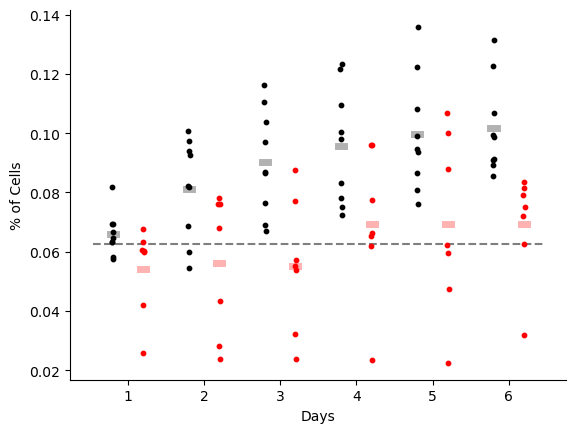

In [19]:
fig,ax = plt.subplots()

ctrl_reward_cells = np.zeros([6,len(ctrl_mice)])
ko_reward_cells = np.zeros([6,len(ko_mice)])

df = pd.DataFrame({'mouse':[],
                    'ko':[],
                    'day':[], 
                    'frac': [], 
                    })

for day in range(6):
    for m, mouse in enumerate(ctrl_mice):
        _hist = get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
        frac = _hist[rz_early[0][0]-5:rz_early[0][0],rz_late[0][0]-5:rz_late[0][0]].sum(axis=-1).sum(axis=-1)
        ctrl_reward_cells[day,m] = frac
        df = pd.concat((df, pd.DataFrame({'mouse': m,
                        'ko': 0,
                        'day': day,
                        'frac': frac}, index=[len(df)])), ignore_index=True)
        
        
    for m, mouse in enumerate(ko_mice):
        _hist = get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
        ko_reward_cells[day,m] = _hist[rz_early[0][0]-5:rz_early[0][0],rz_late[0][0]-5:rz_late[0][0]].sum(axis=-1).sum(axis=-1)
        df = pd.concat((df, pd.DataFrame({'mouse': m+len(ctrl_mice),
                        'ko': 1,
                        'day': day,
                        'frac': frac}, index=[len(df)])), ignore_index=True)
    
for day in range(6):
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_reward_cells[day,:] , color = 'black', s=10)
    ax.plot(5*day  -1 + np.array([-0.2,0.2]), ctrl_reward_cells[day,:].mean()*np.ones([2,]), color='black', linewidth = 5, alpha = .3)
    
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_reward_cells[day,:] , color = 'red', s=10)
    ax.plot(5*day  +1 + np.array([-0.2,0.2]), ko_reward_cells[day,:].mean()*np.ones([2,]), color='red', linewidth = 5, alpha = .3)
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.plot([-2.3, 27.3], ((5/20)**2)*np.ones((2,)), 'k--', zorder= -1, alpha=.5)


# fig.savefig(os.path.join(figdir,"reward_cell_summary.pdf"))
# ko_hist_sm = []
# for mouse in ko_mice:
#     ko_hist_sm.append(get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0)))

# ko_hist_sm = np.array(ko_hist_sm)
# ko_reward_cells = ko_hist_sm[:,rz_early[0][0]-5:rz_early[0][0]-1,rz_late[0][0]-5:rz_late[0][0]-1].sum(axis=-1).sum(axis=-1)

In [20]:
16/(30*30)

0.017777777777777778

(6, 9) (6, 7)
3.3343135813572675 0.0008551019694724832


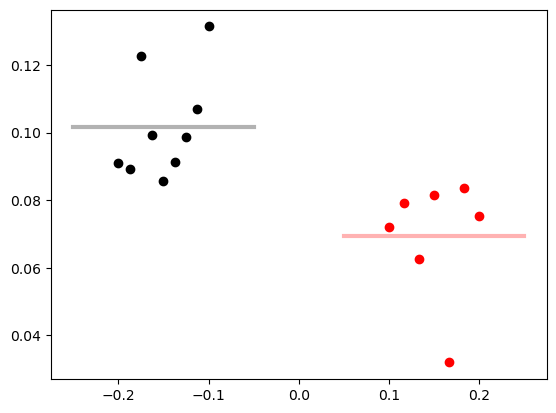

In [22]:
print(ctrl_reward_cells.shape, ko_reward_cells.shape)
t,p = sp.stats.ranksums(ctrl_reward_cells[-1,:], ko_reward_cells[-1,:])
print(t,p)

fig,ax = plt.subplots()
ax.scatter(np.linspace(-.2,-.1,num=len(ctrl_mice)), ctrl_reward_cells[-1,:], color= 'black')
ax.plot(np.array([-.25,-.05]), ctrl_reward_cells[-1,:].mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
ax.scatter(np.linspace(.1,.2,num=len(ko_mice)), ko_reward_cells[-1,:], color= 'red')
ax.plot(np.array([.05,.25]), ko_reward_cells[-1,:].mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)


{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}
{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:834: RuntimeWarning: Mean of empty slice
  r_rm_train.append(np.nanmean(r_trialmat[::2, :, :], axis=0))
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:835: RuntimeWarning: Mean of empty slice
  r_rm_test.append(np.nanmean(r_trialmat[1::2, :, :], axis=0))


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}
{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:834: RuntimeWarning: Mean of empty slice
  r_rm_train.append(np.nanmean(r_trialmat[::2, :, :], axis=0))


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:831: RuntimeWarning: Mean of empty slice
  l_rm_train.append(np.nanmean(l_trialmat[::2, :, :], axis=0))
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:835: RuntimeWarning: Mean of empty slice
  r_rm_test.append(np.nanmean(r_trialmat[1::2, :, :], axis=0))


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}
{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:831: RuntimeWarning: Mean of empty slice
  l_rm_train.append(np.nanmean(l_trialmat[::2, :, :], axis=0))


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}
{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:832: RuntimeWarning: Mean of empty slice
  l_rm_test.append(np.nanmean(l_trialmat[1::2, :, :], axis=0))


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}
{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:834: RuntimeWarning: Mean of empty slice
  r_rm_train.append(np.nanmean(r_trialmat[::2, :, :], axis=0))


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}
{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan

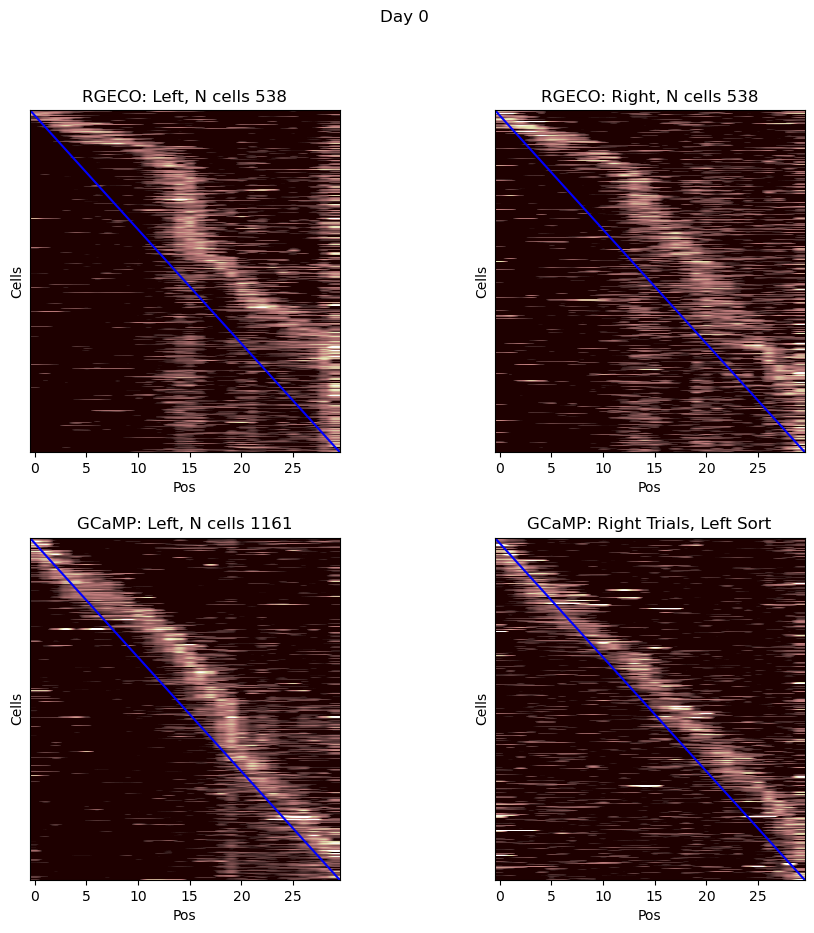

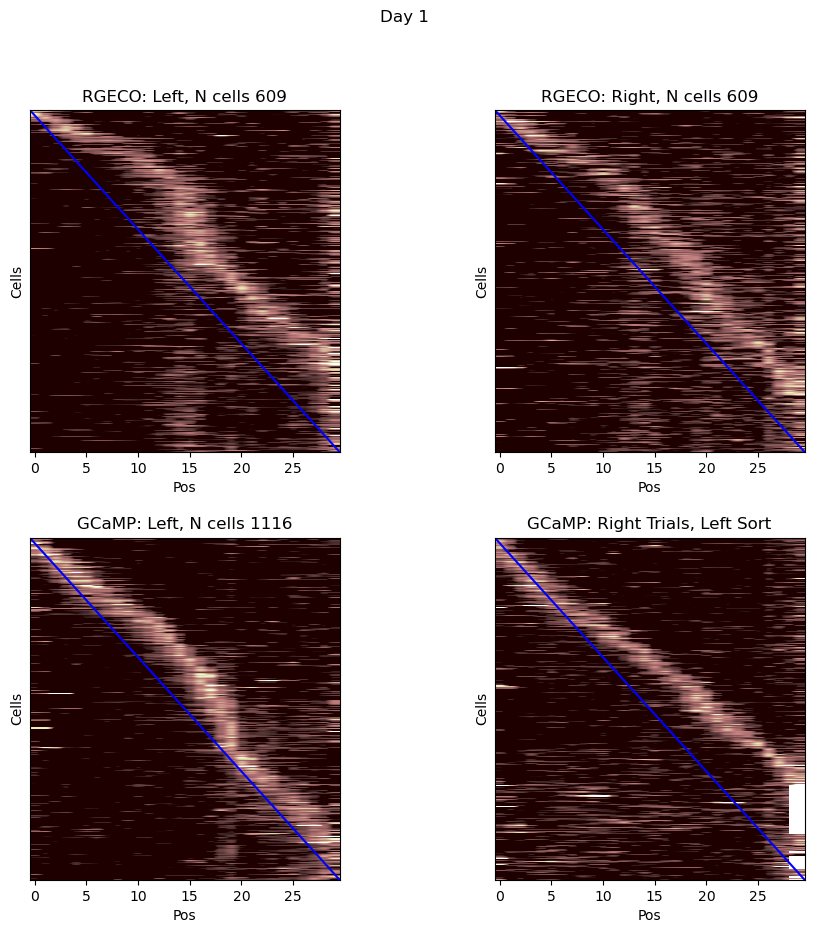

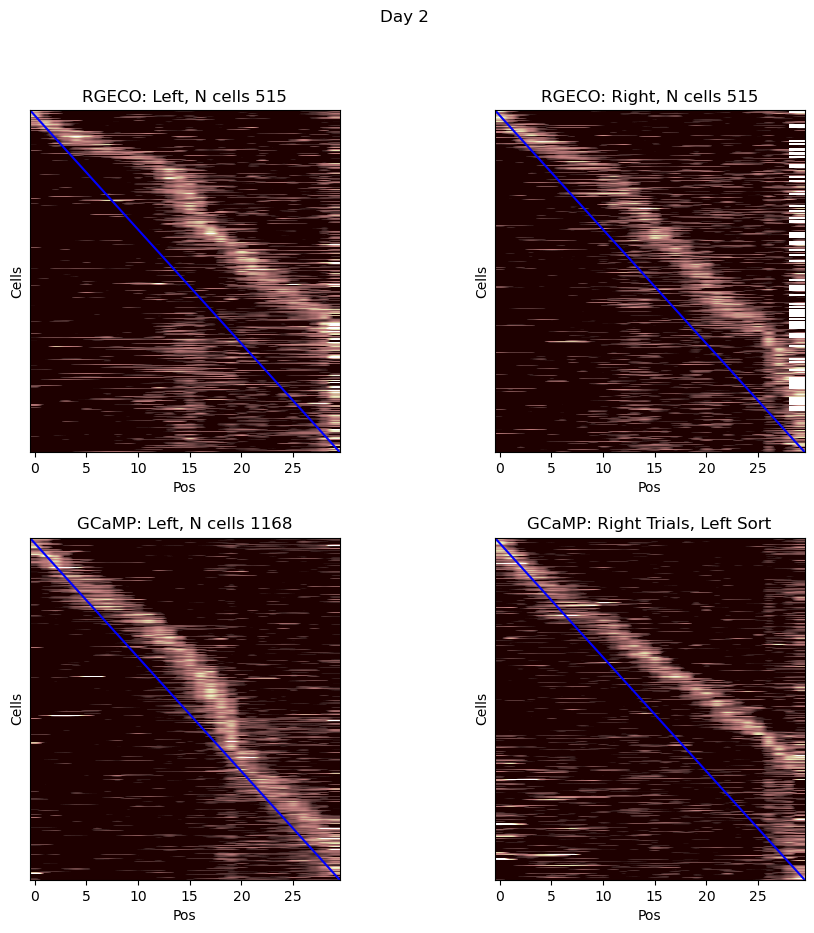

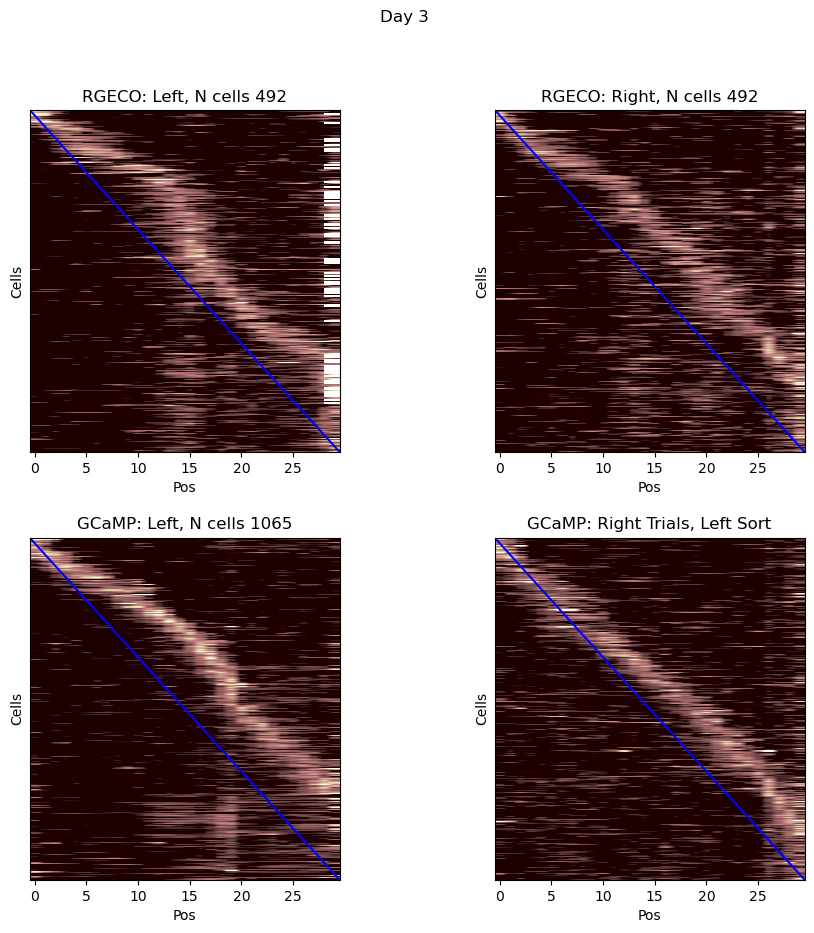

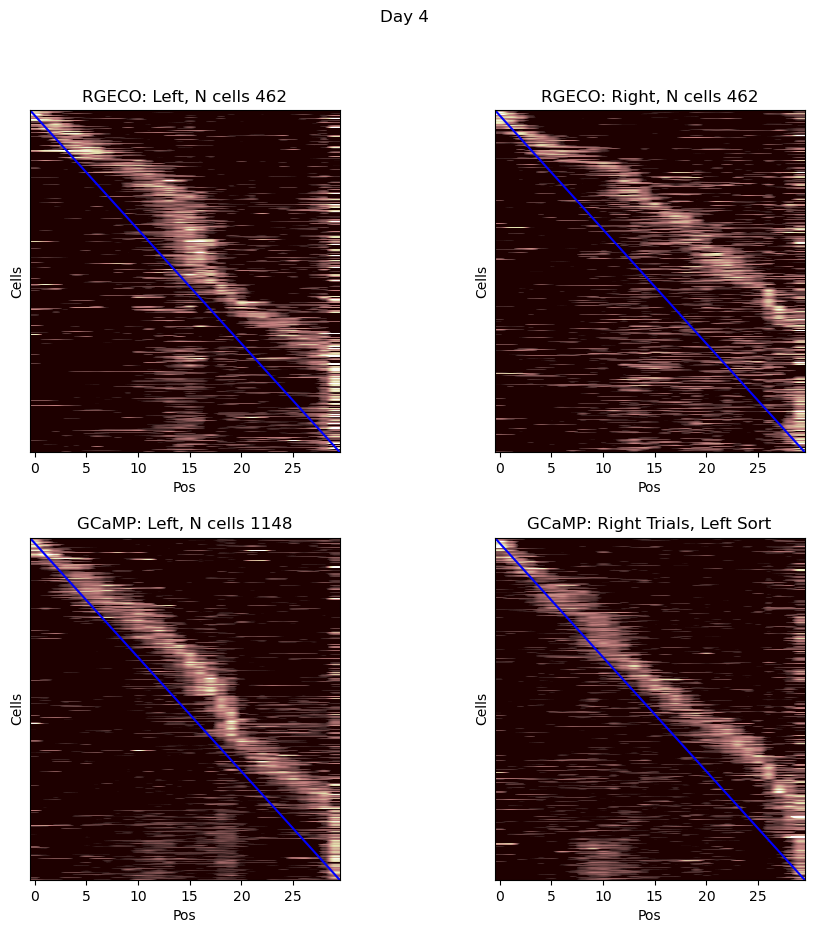

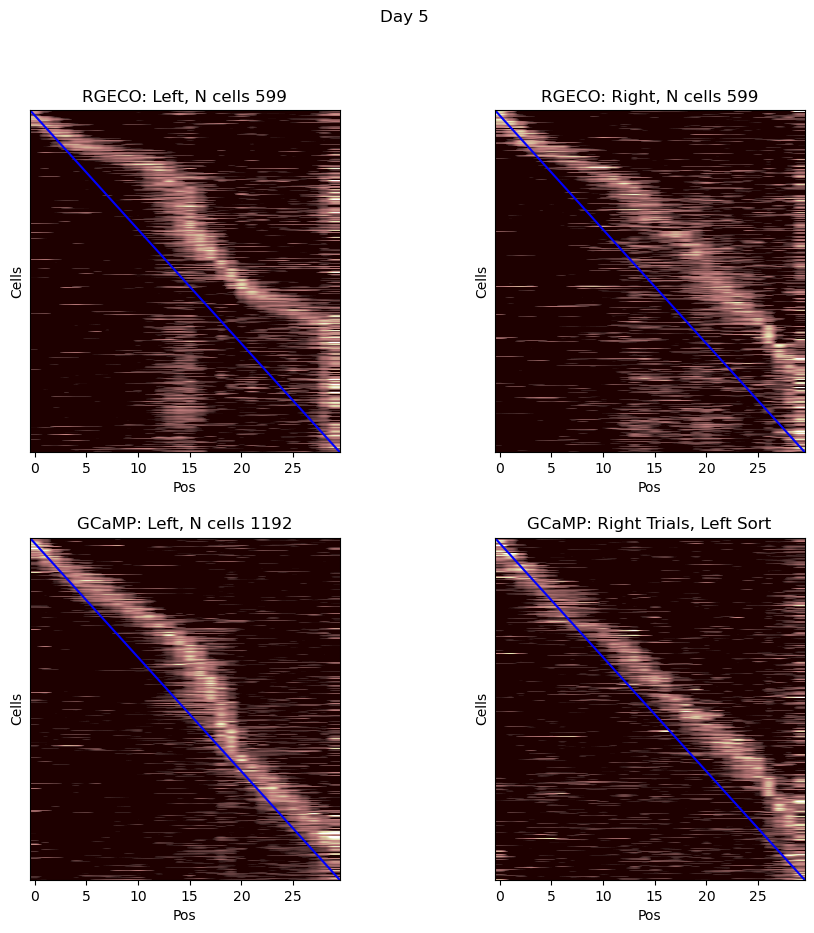

In [47]:
for day in range(0,6):
    fig,ax = stx.reward_overrep.plot_leftright_crossval_placecells_withinday_sparse(day, ts_key = 'spks', vmin = 0, vmax=6)
    # fig.savefig(os.path.join(figdir,"population_placecells_day%d.pdf" % day), format='pdf')

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}
{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:834: RuntimeWarning: Mean of empty slice
  r_rm_train.append(np.nanmean(r_trialmat[::2, :, :], axis=0))
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:835: RuntimeWarning: Mean of empty slice
  r_rm_test.append(np.nanmean(r_trialmat[1::2, :, :], axis=0))


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}
{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:834: RuntimeWarning: Mean of empty slice
  r_rm_train.append(np.nanmean(r_trialmat[::2, :, :], axis=0))


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:831: RuntimeWarning: Mean of empty slice
  l_rm_train.append(np.nanmean(l_trialmat[::2, :, :], axis=0))
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:835: RuntimeWarning: Mean of empty slice
  r_rm_test.append(np.nanmean(r_trialmat[1::2, :, :], axis=0))


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}
{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:831: RuntimeWarning: Mean of empty slice
  l_rm_train.append(np.nanmean(l_trialmat[::2, :, :], axis=0))


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}
{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:832: RuntimeWarning: Mean of empty slice
  l_rm_test.append(np.nanmean(l_trialmat[1::2, :, :], axis=0))


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}
{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:834: RuntimeWarning: Mean of empty slice
  r_rm_train.append(np.nanmean(r_trialmat[::2, :, :], axis=0))


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}
{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan

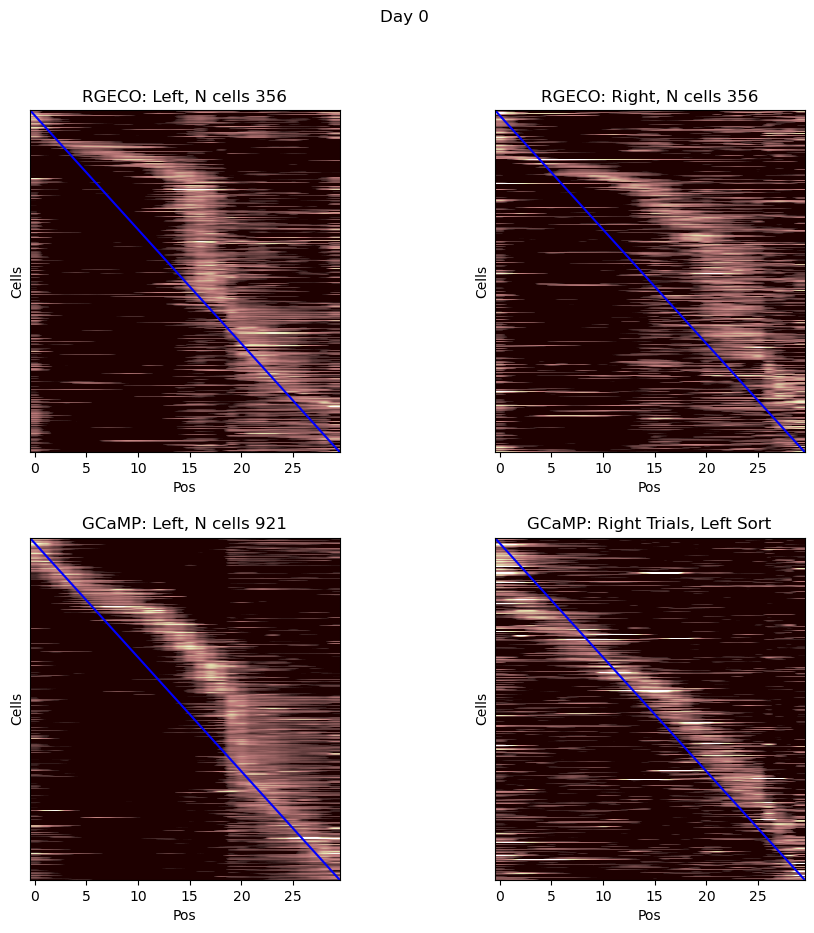

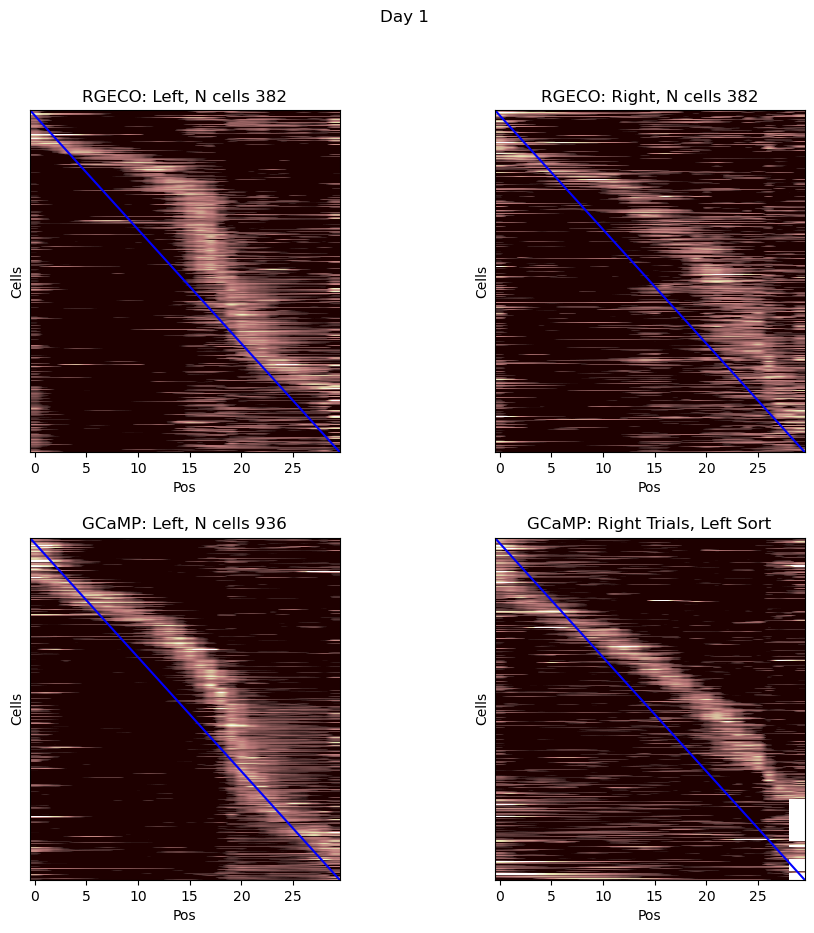

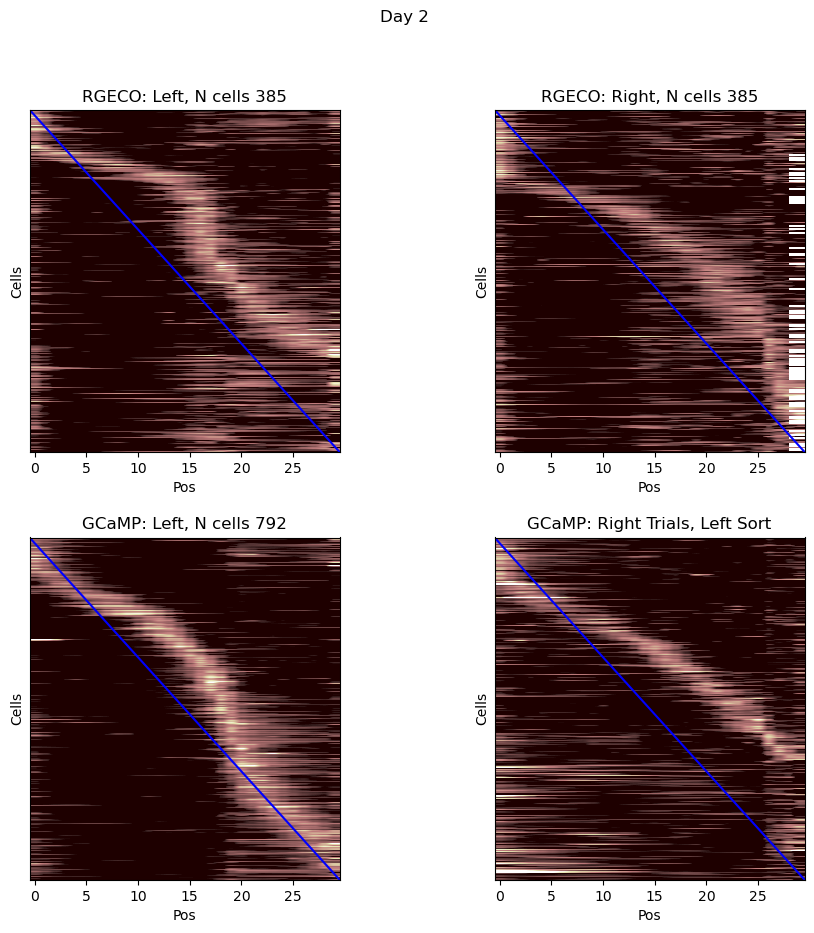

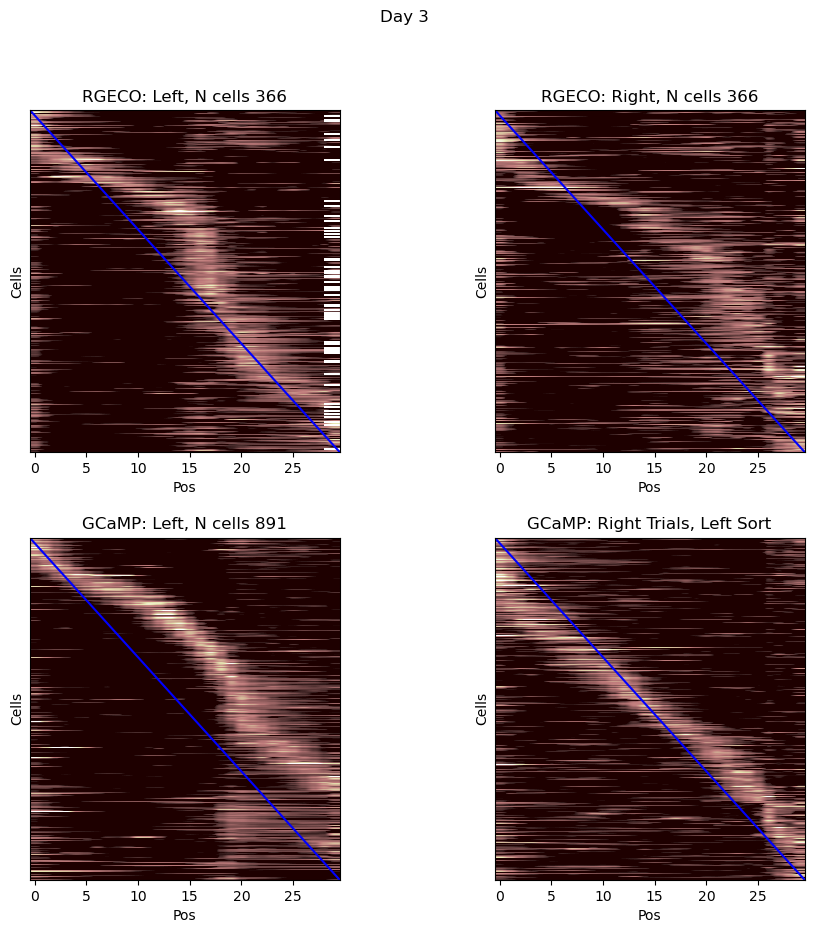

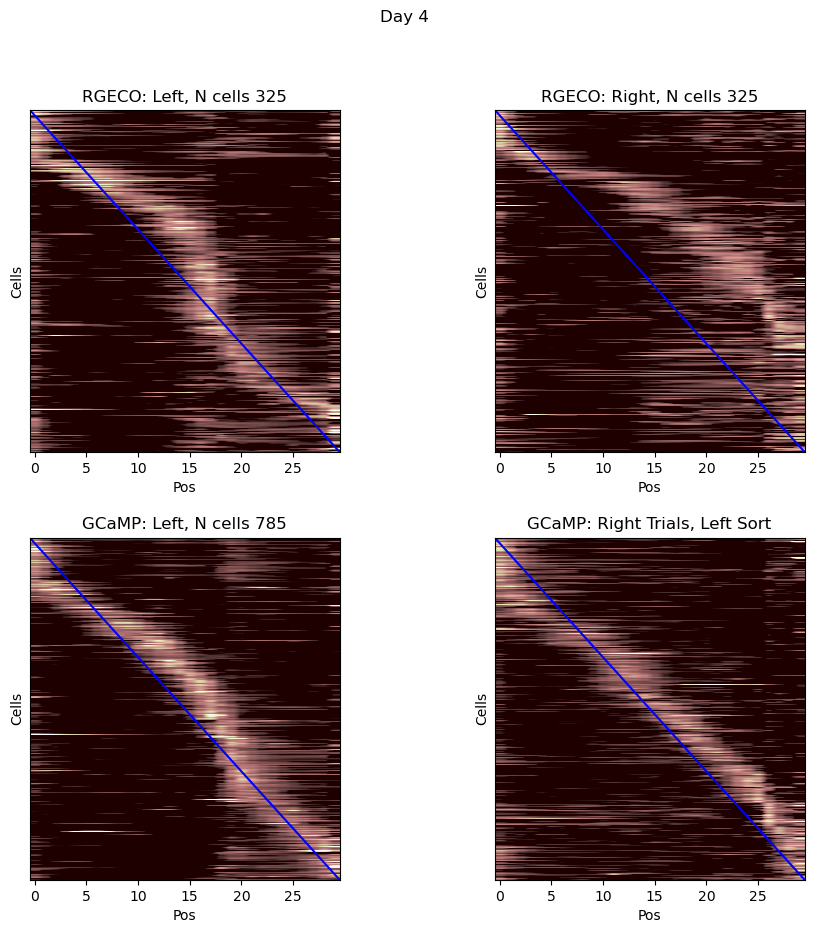

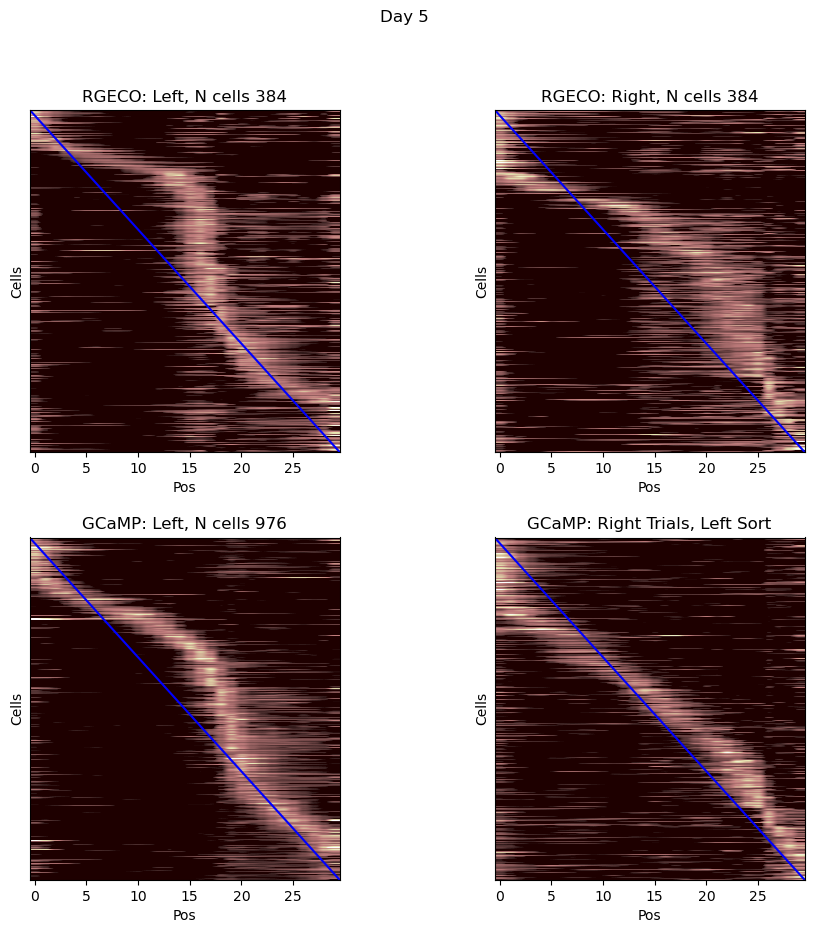

In [10]:
for day in range(0,6):
    fig,ax = stx.reward_overrep.plot_leftright_crossval_placecells_withinday_sparse(day, ts_key = 'F_dff', vmin = 0, vmax=6)
    # fig.savefig(os.path.join(figdir,"population_placecells_day%d.pdf" % day), format='pdf')

In [74]:
class CheckLastBin:

    def __init__(self, days = np.arange(6), ts_key = 'spks_smooth'):

        '''


        :param days:
        :param ts_key:
        '''
        
        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.sparse_mice =stx.ymaze_sess_deets.sparse_mice
        self.__dict__.update({'days': days, 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df_last_bin = pd.DataFrame({'mouse': [],
                        'ko': [],
                        'day': [],
                        'lr': [],
                        'novfam': [],
                        'channel': [],
                        'last_bin_frac': []
                                })
        self.df = pd.DataFrame({'mouse': [],
                    'ko': [],
                    'day': [],
                    'lr': [],
                    'novfam': [],
                    'channel': [],
                    'frac': [],
                    'last_bin_excluded': []
                                })
        self.fill_df()
        

    def fill_df(self):
        # for m, mouse in enumerate(self.ctrl_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse,day),m,0,day)
                
        # for m, mouse in enumerate(self.ko_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse, day),m+len(self.ctrl_mice), 1,day)
                
        for m, mouse in enumerate(self.sparse_mice):
            if mouse == 'SparseKO_12':
                self.days = np.arange(2)
            elif mouse == 'SparseKO_13':
                self.days = np.arange(5)
            else:
                self.days = np.arange(6)
            for day in self.days:
                self.check_last_bin(u.load_single_day(mouse, day),m+len(self.sparse_mice), 1,day) 
                self.argmax_perireward_exclude_last_bin(u.load_single_day(mouse, day),m+len(self.sparse_mice), 1,day) 
   
    @staticmethod
    def get_frac(data):

        # try changing range for spks and see if it makes a diff
        x = np.arange(-30, 15)
        anove_mask = (x>=-6) & (x<=-2)
        hist = np.array([np.count_nonzero(data.ravel() == _bin) for _bin in x.tolist()])
        hist = hist / hist.sum()
        return hist[anove_mask].sum() / hist.sum()   
        
    def check_last_bin(self, sess, m, ko, day, ts_key='spks_smooth'):
        """
       check cells with peak spatial activity in last bin for significant spatial information ~80%? 
        """
    
        for chan in ['channel_0', 'channel_1']:
            trials_mat = sess.trial_matrices[f"{chan}_{ts_key}"]  # shape: (trials, bins, cells)
            bin_edges = sess.trial_matrices['bin_edges']
            n_bins = trials_mat.shape[1]
            last_bin_idx = n_bins - 1
    
            for _arm, arm in enumerate([-1, 1]):
                trial_mask = sess.trial_info['LR'] == arm
                if np.sum(trial_mask) == 0:
                    continue
    
                if sess.novel_arm == arm:
                    cell_mask = sess.nov_place_cell_mask(mux=True, chan=chan)
                    nov = 'nov'
                else:
                    cell_mask = sess.fam_place_cell_mask(mux=True, chan=chan)
                    nov = 'fam'
    
                ratemap = sp.ndimage.gaussian_filter1d(
                    np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0
                )
    

                ratemap = ratemap[:, cell_mask]
                peak_bins = np.argmax(ratemap, axis=0)
    
                # id cells whose peak firing is in the last bin
                last_bin_cells = np.where(peak_bins == last_bin_idx)[0]

    
                # Check for spatial information in the last bin for each trial
                relevant_trials = trials_mat[trial_mask, :, :]
                n_trials = relevant_trials.shape[0]
                spatial_counts = []
    
                for cell_i in last_bin_cells:
                    cell_index = np.where(cell_mask)[0][cell_i]  
                    trial_bin_activity = relevant_trials[:, :, cell_index]  #  (trials, bins)
    
                    # z-score across spatial bins for each trial
                    z_activity = (trial_bin_activity - np.nanmean(trial_bin_activity, axis=1, keepdims=True)) / \
                                 (np.nanstd(trial_bin_activity, axis=1, keepdims=True) + 1e-6)
    
                    # activity > 1.5
                    active_trials = z_activity[:, last_bin_idx] > 1.5
                    spatial_counts.append(np.sum(active_trials) / n_trials)

                if len(spatial_counts) > 0:
                    avg_frac = np.mean(spatial_counts)
                else:
                    avg_frac = np.nan

                if not hasattr(self, 'df_last_bin'):
                    self.df_last_bin = pd.DataFrame()
    
                self.df_last_bin = pd.concat((
                    self.df_last_bin,
                    pd.DataFrame({
                        'mouse': sess.mouse,
                        'ko': ko,
                        'day': day,
                        'lr': _arm,
                        'novfam': nov,
                        'channel': chan,
                        'last_bin_frac': avg_frac
                    }, index=[len(self.df_last_bin)])
                ), ignore_index=True)

        
        
    def argmax_perireward_exclude_last_bin(self, sess, m, ko, day, ts_key: str = 'spks_smooth'):
        '''
        Modified argmax_perireward that excludes the last bin if last_bin_frac < 0.8.
        
        :param sess: session object
        :param m: mouse index
        :param ko: knockout indicator
        :param day: experimental day
        :param ts_key: time series key
        '''
        for chan in ['channel_0', 'channel_1']:
            trials_mat = sess.trial_matrices[f"{chan}_{ts_key}"]
            bin_edges = sess.trial_matrices['bin_edges']
            n_bins = trials_mat.shape[1]
            
            for _arm, arm in enumerate([-1, 1]):
                trial_mask = sess.trial_info['LR'] == arm
                if np.sum(trial_mask) == 0:
                    continue
    
                # Determine novel vs familiar
                if sess.novel_arm == arm:
                    cell_mask = sess.nov_place_cell_mask(mux=True, chan=chan, key = ts_key)
                    rzone_front = np.argwhere(
                        (sess.rzone_nov['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_nov['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'nov'
                else:
                    cell_mask = sess.fam_place_cell_mask(mux=True, chan=chan, key = ts_key)
                    rzone_front = np.argwhere(
                        (sess.rzone_fam['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_fam['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'fam'
    
                # Get whether to exclude last bin
                matching_row = self.df_last_bin[
                    (self.df_last_bin['mouse'] == sess.mouse) &
                    (self.df_last_bin['ko'] == ko) &
                    (self.df_last_bin['day'] == day) &
                    (self.df_last_bin['lr'] == _arm) &
                    (self.df_last_bin['novfam'] == nov) &
                    (self.df_last_bin['channel'] == chan)
                ]
    
                exclude_last_bin = False
                if not matching_row.empty:
                    last_bin_frac = matching_row['last_bin_frac'].values[0]
                    if last_bin_frac < 0.8:
                        exclude_last_bin = True
    
                # Compute ratemap
                ratemap = sp.ndimage.gaussian_filter1d(
                    np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0
                )
    
                if exclude_last_bin:
                    ratemap[-1, :] = np.nan  # mask out the last bin if not reliable

                
                max_inds = np.nanargmax(ratemap[:, cell_mask], axis=0)
                aligned_max_inds = max_inds - rzone_front
    
                reward_frac = self.get_frac(aligned_max_inds)
    
                self.df = pd.concat((
                    self.df,
                    pd.DataFrame({
                        'mouse': sess.mouse,
                        'ko': ko,
                        'day': day,
                        'lr': _arm,
                        'novfam': nov,
                        'channel': chan,
                        'frac': reward_frac,
                        'last_bin_excluded': exclude_last_bin
                    }, index=[len(self.df)])
                ), ignore_index=True)

        


In [75]:
last_bin_frac = CheckLastBin()

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_153564\4080511870.py:209: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self.df = pd.concat((


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session':

In [73]:
class AnySigField:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''
        self.sparse_mice =stx.ymaze_sess_deets.sparse_mice
        self.__dict__.update({'days': days, 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse': [],
                    'ko': [],
                    'day': [],
                    'lr': [],
                    'novfam': [],
                    'channel': [],
                    'frac': []
                                })
        self.fill_df()
        

    def fill_df(self):
        # for m, mouse in enumerate(self.ctrl_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse,day),m,0,day)
                
        # for m, mouse in enumerate(self.ko_mice):
        #     for day in self.days:
        #         self.argmax_perireward(u.load_single_day(mouse, day),m+len(self.ctrl_mice), 1,day)
                
        for m, mouse in enumerate(self.sparse_mice):
            if mouse == 'SparseKO_13':
                self.days = np.arange(5)
            elif mouse == 'SparseKO_09':
                self.days = np.arange(5)
            else:
                self.days = np.arange(6)
            for day in self.days:
                # self.check_last_bin(u.load_single_day(mouse, day),m+len(self.sparse_mice), 1,day) 
                self.argmax_perireward_all_sig_fields(u.load_single_day(mouse, day),m+len(self.sparse_mice), 1,day) 
        
    def argmax_perireward_all_sig_fields(self, sess, m, ko, day, ts_key: str = 'spks'):
        '''
        Modified argmax_perireward that excludes the last bin if last_bin_frac < 0.8.
        
        :param sess: session object
        :param m: mouse index
        :param ko: knockout indicator
        :param day: experimental day
        :param ts_key: time series key
        '''
        for chan in ['channel_0', 'channel_1']:
            key = f"{chan}_{ts_key}"
            trials_mat = sess.trial_matrices[f"{chan}_{ts_key}"]
            bin_edges = sess.trial_matrices['bin_edges']
            n_bins = trials_mat.shape[1]
            
            for _arm, arm in enumerate([-1, 1]):
                trial_mask = sess.trial_info['LR'] == arm
                if np.sum(trial_mask) == 0:
                    continue
    
                # Determine novel vs familiar
                if sess.novel_arm == arm:
                    rzone_front = np.argwhere(
                        (sess.rzone_nov['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_nov['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'nov'
                else:
                    # cell_mask = sess.fam_place_cell_mask(mux=True, chan=chan, key = ts_key)
                    rzone_front = np.argwhere(
                        (sess.rzone_nov['tfront'] <= bin_edges[1:]) &
                        (sess.rzone_nov['tfront'] >= bin_edges[:-1])
                    )[0][0]
                    nov = 'fam'
    
                # Compute significant fields 
                trial_mat = trials_mat[trial_mask, :, :]
                field_masks = self._compute_sig_field_mask(trial_mat, n_perms = 1000, pcnt = 99)

                n_cells = field_masks.shape[1]
                reward_zone_bins = np.arange(rzone_front -5, rzone_front)
                
                field_in_rzone = np.array([
                    np.any(field_masks[:, i][reward_zone_bins])
                    for i in range(n_cells)
                ])
                reward_frac = np.mean(field_in_rzone)

                
    
                self.df = pd.concat((
                    self.df,
                    pd.DataFrame({
                        'mouse': sess.mouse,
                        'ko': ko,
                        'day': day,
                        'lr': _arm,
                        'novfam': nov,
                        'channel': chan,
                        'frac': reward_frac
                    }, index=[len(self.df)])
                ), ignore_index=True)
    @staticmethod

    def _compute_sig_field_mask(trial_mat, n_perms, pcnt):
        rng = np.random.default_rng(seed=0)
        n_trials, n_bins, n_cells = trial_mat.shape
        shuff_mat = np.zeros((n_perms, n_bins, n_cells))
        shuffs = rng.integers(n_bins, size=(n_perms, n_trials))

        for perm in range(n_perms):
            _tmat = np.zeros_like(trial_mat)
            for trial in range(n_trials):
                _tmat[trial, :, :] = np.roll(trial_mat[trial, :, :], shuffs[perm, trial], axis = 0)
            shuff_mat[perm] = np.nanmean(_tmat, axis = 0)

        thresh = np.nanpercentile(shuff_mat, pcnt, axis = 0)
        real_mean = np.nanmean(trial_mat, axis = 0)
        field_mask = real_mean > thresh

        return field_mask

In [252]:
any_sig_field = AnySigField()

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1,

C:\Users\esay\AppData\Local\Temp\ipykernel_156172\3281716309.py:134: RuntimeWarning: Mean of empty slice
  real_mean = np.nanmean(trial_mat, axis = 0)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


In [51]:
last_bin_frac.df

mouse   ko  day   lr novfam    channel      frac  last_bin_excluded
0   SparseKO_02  1.0  0.0  0.0    nov  channel_0  0.237288                0.0
1   SparseKO_02  1.0  0.0  1.0    fam  channel_0  0.157895                0.0
2   SparseKO_02  1.0  0.0  0.0    nov  channel_1  0.194444                0.0
3   SparseKO_02  1.0  0.0  1.0    fam  channel_1  0.071429                0.0
4   SparseKO_02  1.0  1.0  0.0    nov  channel_0  0.176471                0.0
5   SparseKO_02  1.0  1.0  1.0    fam  channel_0  0.180328                0.0
6   SparseKO_02  1.0  1.0  0.0    nov  channel_1  0.170732                0.0
7   SparseKO_02  1.0  1.0  1.0    fam  channel_1  0.141176                0.0
8   SparseKO_02  1.0  2.0  0.0    nov  channel_0  0.277108                0.0
9   SparseKO_02  1.0  2.0  1.0    fam  channel_0  0.186170                0.0
10  SparseKO_02  1.0  2.0  0.0    nov  channel_1  0.363636                0.0
11  SparseKO_02  1.0  2.0  1.0    fam  channel_1  0.135135                0.0
12  SparseKO_02  1.0  3.0  0.0    nov  channel_0  0.200000                0.0
13  SparseKO_02  1.0  3.0  1.0    fam  channel_0  0.198347                0.0
14  SparseKO_02  1.0  3.0  0.0    nov  channel_1  0.312500                0.0
15  SparseKO_02  1.0  3.0  1.0    fam  channel_1  0.282051                0.0
16  SparseKO_02  1.0  4.0  0.0    nov  channel_0  0.243056                0.0
17  SparseKO_02  1.0  4.0  1.0    fam  channel_0  0.142857                0.0
18  SparseKO_02  1.0  4.0  0.0    nov  channel_1  0.300000                0.0
19  SparseKO_02  1.0  4.0  1.0    fam  channel_1  0.200000                0.0
20  SparseKO_02  1.0  5.0  0.0    nov  channel_0  0.207865                0.0
21  SparseKO_02  1.0  5.0  1.0    fam  channel_0  0.177515                0.0
22  SparseKO_02  1.0  5.0  0.0    nov  channel_1  0.200000                0.0
23  SparseKO_02  1.0  5.0  1.0    fam  channel_1  0.288462                0.0

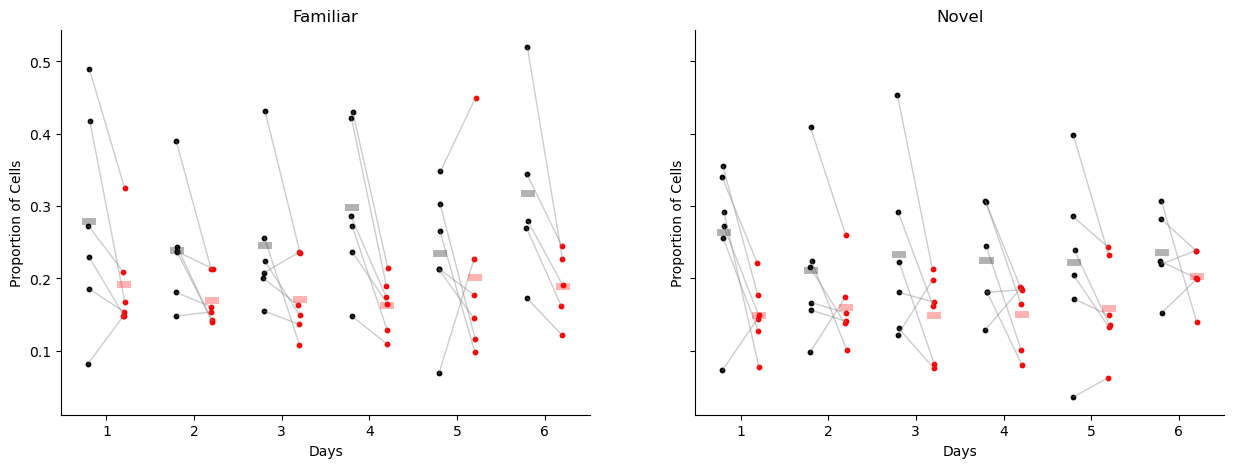

In [76]:
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
s = 10
lw = 5

for day in range(6):
    for novfam, axis_idx in zip(['fam', 'nov'], [0, 1]):
        frac_ch1 = []
        frac_ch0 = []
        xvals_ch1 = []
        xvals_ch0 = []

        for i, mouse in enumerate(sparse_mice):
            mask_ch1 = (
                (last_bin_frac.df['channel'] == 'channel_1') &
                (last_bin_frac.df['day'] == day) &
                (last_bin_frac.df['novfam'] == novfam) &
                (last_bin_frac.df['mouse'] == mouse)
            )
            mask_ch0 = (
                (last_bin_frac.df['channel'] == 'channel_0') &
                (last_bin_frac.df['day'] == day) &
                (last_bin_frac.df['novfam'] == novfam) &
                (last_bin_frac.df['mouse'] == mouse)
            )

            vals_ch1 = last_bin_frac.df['frac'].loc[mask_ch1]._values
            vals_ch0 = last_bin_frac.df['frac'].loc[mask_ch0]._values

            x1 = 5 * day - 1 if novfam == 'fam' else 5 * day - 1
            x0 = 5 * day + 1 if novfam == 'fam' else 5 * day + 1
            offset = np.linspace(-0.05, 0.05, num=len(sparse_mice))[i]

            if len(vals_ch1):
                frac = vals_ch1.mean()
                frac_ch1.append(frac)
                xvals_ch1.append(x1 + offset)
                ax[axis_idx].scatter(x1 + offset, frac, color='black', s=s)

            if len(vals_ch0):
                frac = vals_ch0.mean()
                frac_ch0.append(frac)
                xvals_ch0.append(x0 + offset)
                ax[axis_idx].scatter(x0 + offset, frac, color='red', s=s)

            # Draw line between ch1 and ch0 points for this mouse if both exist
            if len(vals_ch1) and len(vals_ch0):
                ax[axis_idx].plot(
                    [x1 + offset, x0 + offset],
                    [vals_ch1.mean(), vals_ch0.mean()],
                    color='gray', alpha=0.4, linewidth=1
                )

        # Plot group mean bars
        if frac_ch1:
            ax[axis_idx].plot(
                x1 + np.array([-0.2, 0.2]),
                [np.mean(frac_ch1)] * 2,
                color='black', linewidth=lw, alpha=0.3
            )
        if frac_ch0:
            ax[axis_idx].plot(
                x0 + np.array([-0.2, 0.2]),
                [np.mean(frac_ch0)] * 2,
                color='red', linewidth=lw, alpha=0.3
            )

ax[0].set_title('Familiar')
ax[1].set_title('Novel')

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Proportion of Cells")
    ax[a].set_xticks(5 * np.arange(6))
    ax[a].set_xticklabels(np.arange(1, 7))



In [77]:
import pingouin as pg
nov = last_bin_frac.df[last_bin_frac.df['novfam'] == 'nov']
fam = last_bin_frac.df[last_bin_frac.df['novfam'] == 'fam']
pg.rm_anova(data=nov, dv='frac', within='channel', subject='mouse', correction='auto', detailed=False, effsize='ng2')


Source  ddof1  ddof2         F     p-unc       ng2  eps
0  channel      1      5  6.514804  0.051116  0.293253  1.0

In [78]:
pg.rm_anova(data=fam, dv='frac', within='channel', subject='mouse', correction='auto', detailed=False, effsize='ng2')

Source  ddof1  ddof2          F     p-unc       ng2  eps
0  channel      1      5  19.462243  0.006946  0.384779  1.0

In [173]:
# population plots with last bin cleared if not enough spatial information (NEED TO FIX SORTING) 
def plot_leftright_crossval_placecells_withinday_sparse(day, ts_key = 'spks', vmin = -.25, vmax = 5):
    '''

    :param day:
    :param ts_key:
    :return:
    '''
    def mask_last_bin(mouse, day, ko, lr, chan, novfam):
        df = last_bin_frac.df_last_bin
        row = df[
        (df['mouse']==mouse) &
        (df['ko'] == ko) &
        (df['day'] == day) &
        (df['lr'] == _arm) &
        (df['novfam'] == nov) &
        (df['channel'] == chan)
        ]
        if not row.empty:
            return row['last_bin_frac'].values[0] < 0.8 
        return False

    def lr_ratemaps(mice, chan, ko_val=1):
        '''

        :param mice:
        :return:
        '''
        l_rm_train, l_rm_test, r_rm_train, r_rm_test = [], [], [], []
        for mouse in mice:
            sess = u.load_single_day(mouse, day)
            key = chan + '_' + ts_key
            if 'left' in sess.place_cell_info[key].keys():
                l_cellmask = sess.place_cell_info[key]['left']['masks']
                r_cellmask= sess.place_cell_info[key]['left']['masks']
            else:
                l_cellmask = sess.place_cell_info[key][-1]['masks'].sum(axis=0)>0
                r_cellmask = sess.place_cell_info[key][1]['masks'].sum(axis=0) > 0

            trial_mat = sess.trial_matrices[key]
            n_bins = trial_mat.shape[1]
            for lr_val, cellmask, label in [(-1, l_cellmask, 'left'), (1, r_cellmask, 'right')]:
                trialmask = sess.trial_info['LR'] == lr_val
                trialmat = trial_mat[trialmask, :, :][:,:, cellmask]

                novfam = 'nov' if sess.novel_arm == lr_val else 'fam'

                if last_bin_frac and mask_last_bin (mouse, day, ko_val, 0 if lr_val ==-1 else 1, chan, novfam):
                    trialmat[:, -1,:] = np.nan
                train = np.nanmean(trialmat[::2], axis = 0)
                test = np.nanmean(trialmat[1::2], axis = 0)

                if lr_val == -1:
                    l_rm_train.append(train)
                    l_rm_test.append(test)
                else:
                    r_rm_train.append(train)
                    r_rm_test.append(test)


        return np.concatenate(l_rm_train, axis=-1), np.concatenate(l_rm_test, axis=-1), \
               np.concatenate(r_rm_train, axis=-1), np.concatenate(r_rm_test, axis=-1)

    def sort_norm(rm_train, rm_test):
        mu, std = np.nanmean(rm_train, axis=0, keepdims=True), np.nanstd(rm_train, axis=0, keepdims=True)
        sortvec = np.argsort(np.argmax(rm_train, axis=0))

        rm_test = (rm_test-mu)/std

        return rm_test[:, sortvec]

    ko_l_train, ko_l_test, ko_r_train, ko_r_test = lr_ratemaps(sparse_mice, 'channel_0')
    ctrl_l_train, ctrl_l_test, ctrl_r_train, ctrl_r_test = lr_ratemaps(sparse_mice, 'channel_1')

    fig, ax = plt.subplots(2,2, figsize= [10,10])
    ax[0,0].imshow(sort_norm(ctrl_l_train, ctrl_l_test).T, cmap='pink', aspect='auto', vmin=vmin, vmax=vmax)
    ax[0,1].imshow(sort_norm(ctrl_r_train, ctrl_r_test).T, cmap='pink', aspect='auto', vmin=vmin, vmax=vmax)

    ax[0,0].plot([-.5, ctrl_l_train.shape[0]- .5], [-.5, ctrl_l_train.shape[1]-.5], color='blue')
    ax[0,1].plot([-.5, ctrl_r_train.shape[0] - .5], [-.5, ctrl_r_train.shape[1] - .5], color='blue')

    ax[0, 0].set_title("RGECO: Left, N cells %d" % ctrl_l_test.shape[1])
    ax[0, 1].set_title("RGECO: Right, N cells %d" % ctrl_r_test.shape[1])

   
    ax[1, 0].imshow(sort_norm(ko_l_train, ko_l_test).T, cmap='pink', aspect='auto', vmin=vmin, vmax=vmax)
    ax[1, 0].plot([-.5, ko_l_train.shape[0]- .5], [-.5, ko_l_train.shape[1]-.5], color='blue')
    ax[1, 0].set_title(f"GCaMP: Left, N cells {ko_l_test.shape[1]}")

    ax[1, 1].imshow(sort_norm(ko_r_train, ko_r_test).T, cmap='pink', aspect='auto', vmin=vmin, vmax=vmax)
    ax[1, 1].plot([-.5, ko_l_train.shape[0]- .5], [-.5, ko_l_train.shape[1]-.5], color='blue')
    ax[1, 1].set_title("GCaMP: Right Trials, Left Sort")

    for row in [0,1]:
        for col in [0,1]:
            ax[row,col].set_yticks([])
            ax[row,col].set_ylabel('Cells')
            ax[row, col].set_xlabel('Pos')

    fig.subplots_adjust(hspace=.25, wspace=.5)
    fig.suptitle('Day %d' % day)
    return fig, ax

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:49: RuntimeWarning: Mean of empty slice
  train = np.nanmean(trialmat[::2], axis = 0)
C:\Users\esay\AppData\Local\Temp\ipykernel_156172\2227379104.py:50: RuntimeWarning: Mean of empty slice
  test = np.nanmean(trialmat[1::2], axis = 0)


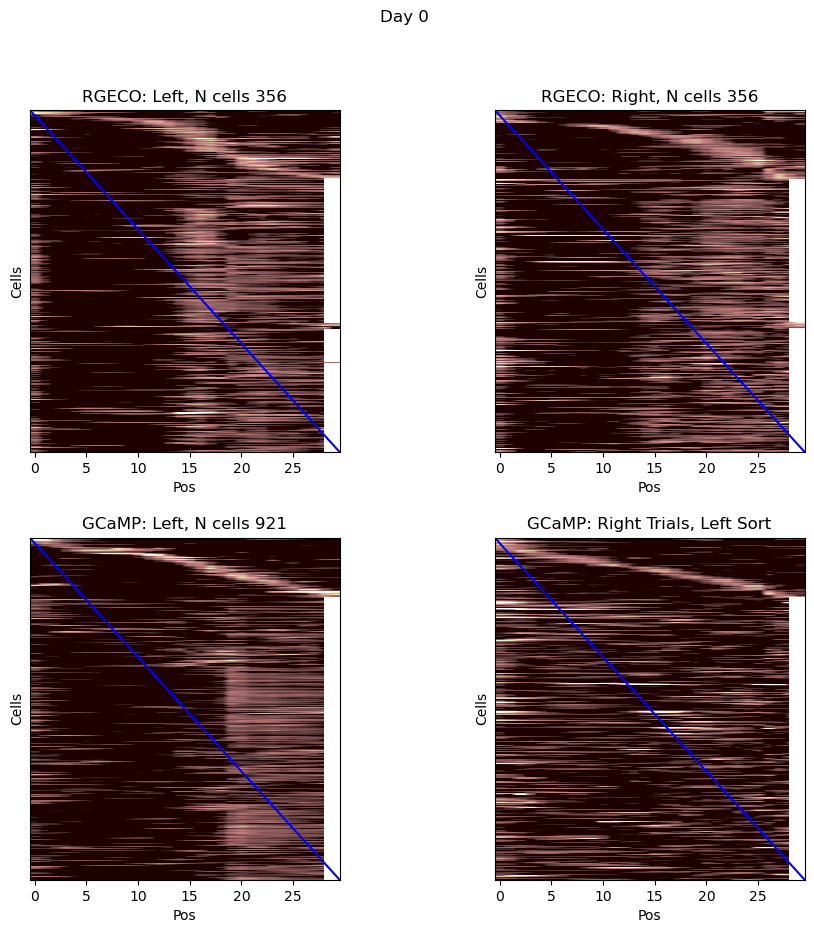

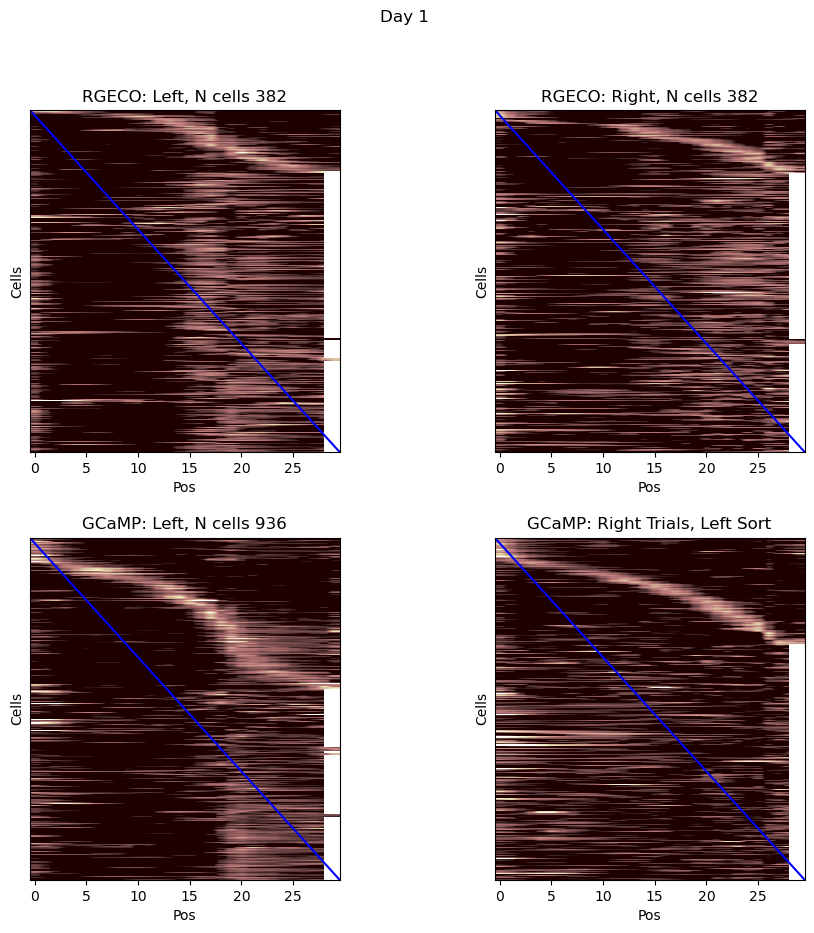

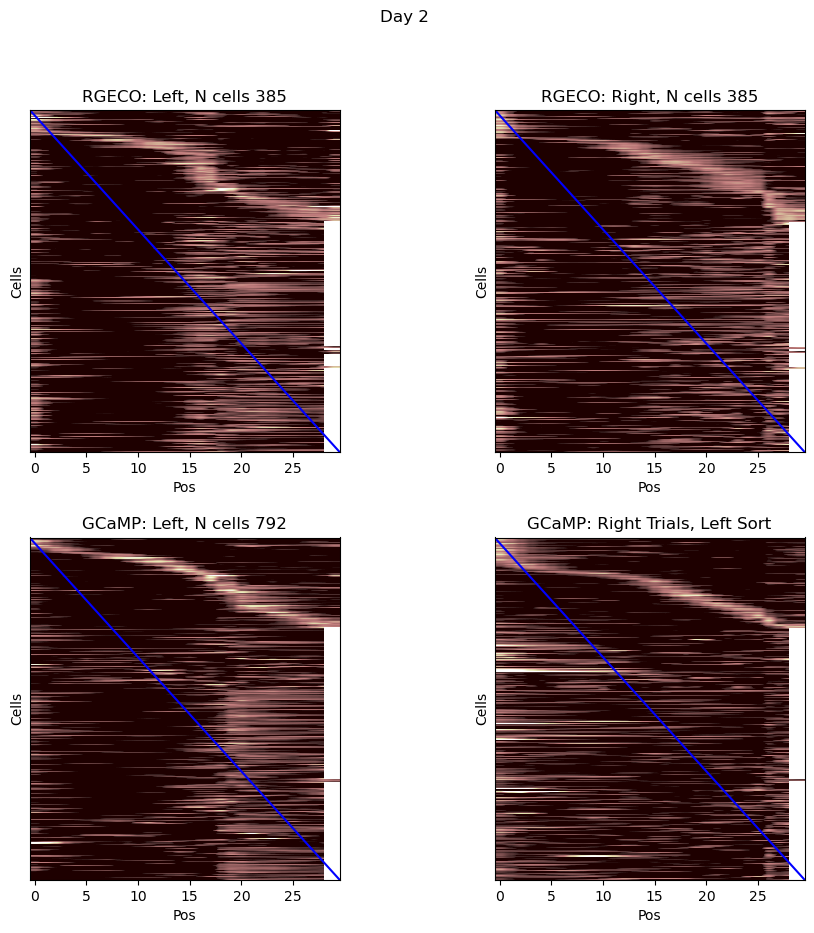

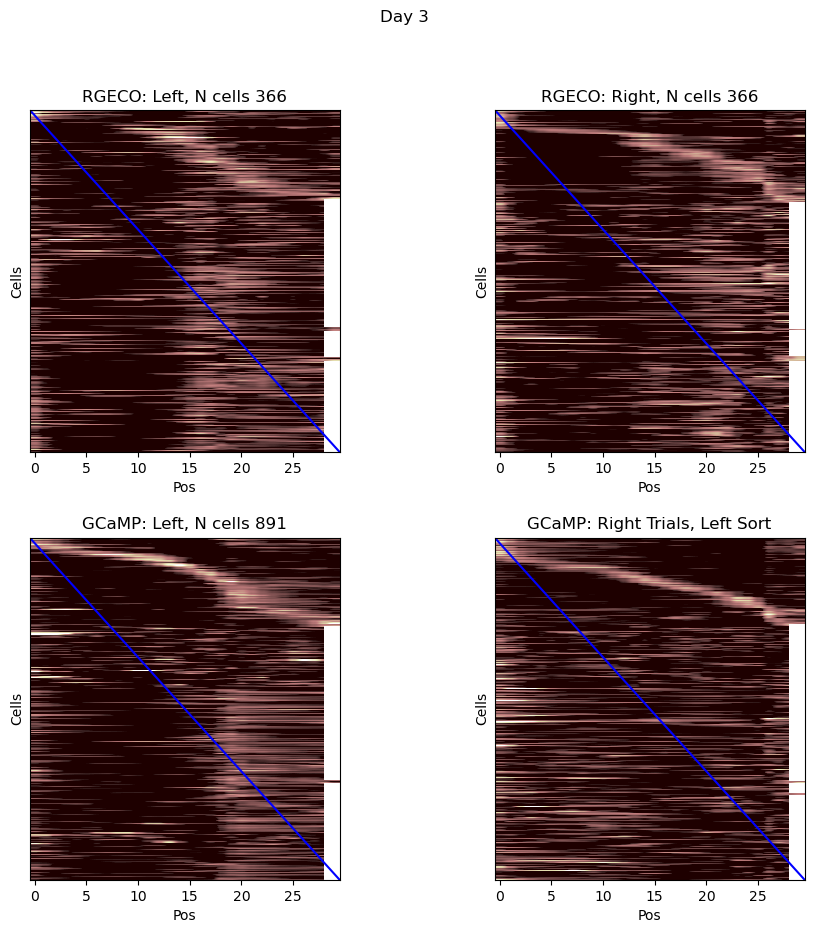

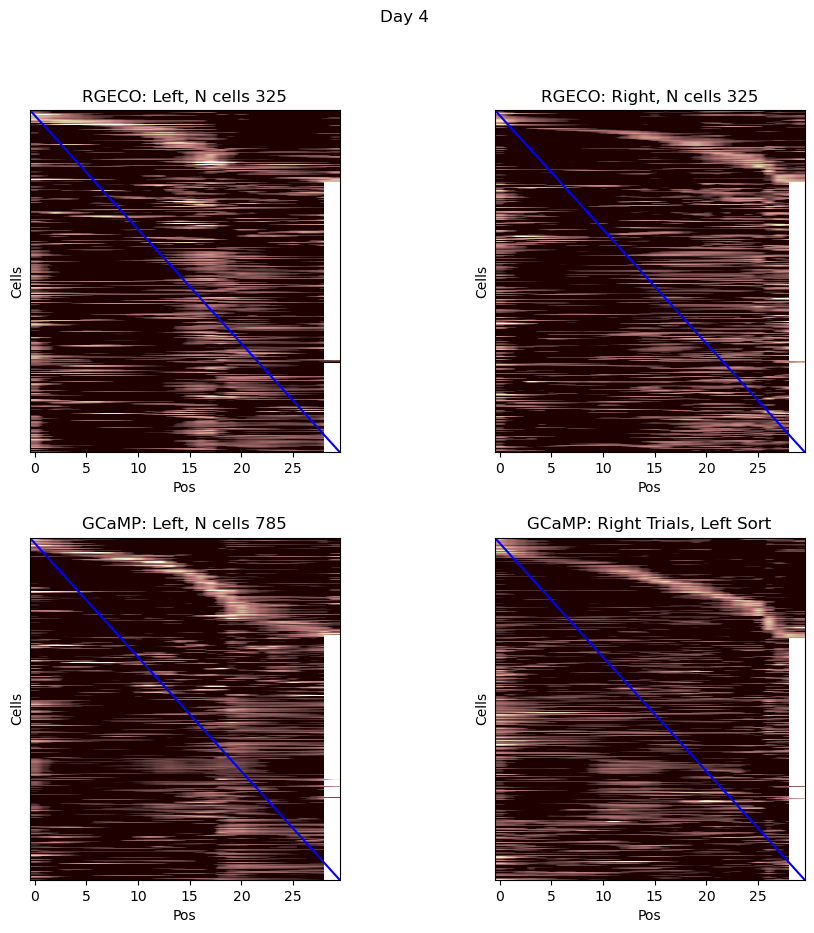

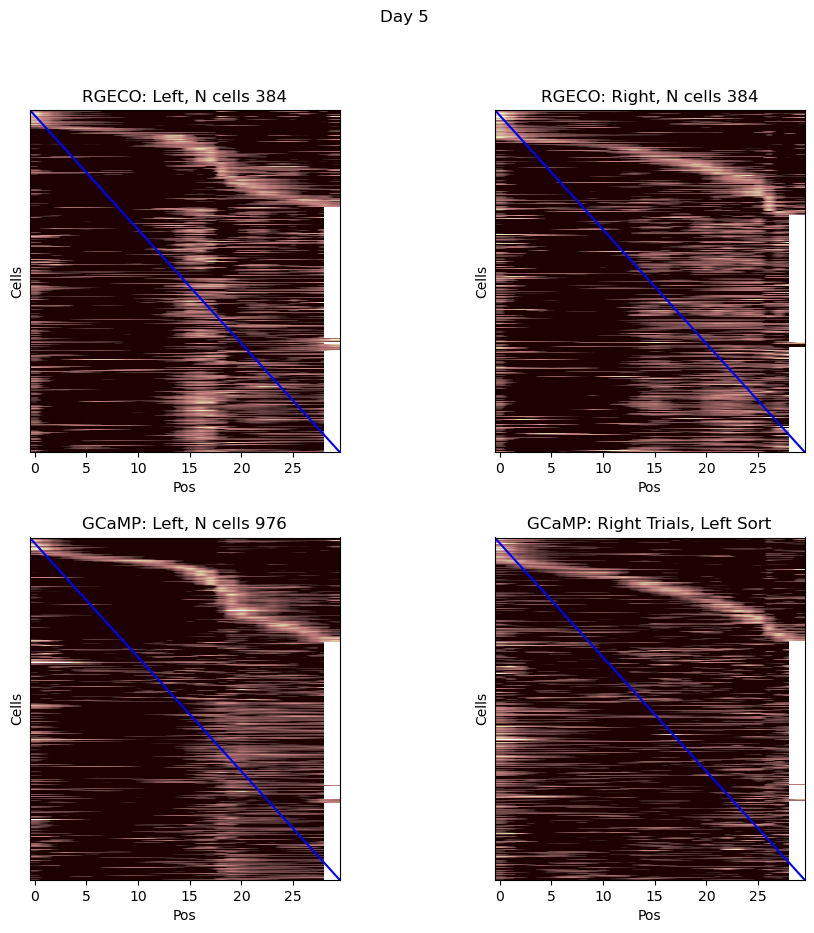

In [172]:
for day in range(0,6):
    fig,ax = plot_leftright_crossval_placecells_withinday_sparse(day, ts_key = 'F_dff', vmin = 0, vmax=6)

In [164]:
sparse_mice

('SparseKO_02',
 'SparseKO_06',
 'SparseKO_08',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')